# **Problem Statement**
The objective of this research is to determine the effectiveness of machine learning models in predicting stock price movements to generate profitable trading strategies. Specifically, this study develops and evaluates Random Forest, XGBoost, and LGBM models for Apple Inc. (AAPL) to assess their predictive capabilities. Model performance is measured using conventional error metrics (MAE/MSE) and a secondary performance metric, cumulative return, which is benchmarked against a traditional buy-and-hold strategy. This research aims to identify whether machine learning-driven trading models can outperform passive investment strategies in terms of profitability.

# **Model Outcomes**
Each model is designed to predict the next day's high and low for the target asset, providing critical and actionable inputs for calculating risk-reward ratios for potential long (buy) and short (sell) trades. These forecasts enable informed decision-making, improving trade entry strategies and overall risk management
.# **
Data Acquisiti**on
AAPL was selected as the target asset due to its extensive historical data spanning over 40 years and its market significance in terms of capitalization, liquidity, and ETF weighting. Data from 2008 to the present was utilized to account for evolving market conditions. AAPL's strong correlations with key indices—S&P 500 (SPY), NASDAQ (QQQ), and the U.S. dollar currency index (DX-Y.NYB)—further support its suitability for analysis. All data was sourced from Yahoo Finance (yfinance python library), with the dataset containing 4,316 rows from January 1, 2008, to March 1, 2025, prior to processing.


In [2]:
!pip install yfinance
!pip install lightgbm
!pip install mplfinance
!pip install xgboost

#pip install --upgrade yfinance

In [3]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from sklearn.compose import make_column_transformer, make_column_selector
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

In [4]:
#### Get Data

# Define multiple symbols
symbols = ['AAPL', 'SPY', 'QQQ', 'DX-Y.NYB']

# Define the date range
start_date = '2008-01-01'
end_date = '2025-03-01'

# Download the data
df = yf.download(symbols, start=start_date, end=end_date, group_by='ticker')

# Convert to CSV file
df.to_csv('historical_stock_data.csv')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


# **Data Preprocessing, Target Definition, and Visualizations**
Each of our 4 assets ('AAPL', 'SPY', 'QQQ', 'DX-Y.NYB) contains 5 columns, for a total of 20 columns in our df. We begin by relabling the columns for easier use, drop columns that will not be used, then inspect and handle rows with nan, inf, or zero values in the resulting df. Finally in this section, we generate visualizations.

### Defining a Meaningful Target 
The objective of this analysis is to develop a strategy for profitably trading stocks by making informed decisions to buy (go long) or sell (go short) based on the next period’s (tomorrow’s) high and low prices relative to today's closing price (entry price). To achieve this, we first define our target variables as the next period's high and low prices:

df['target_high'] = df['AAPL_High'].shift(-1)
df['target_low'] = df['AAPL_Low'].shift(-1)

Next, we express these targets as potential returns from the current closing price:

df['target_long_returns'] = df['target_high'] - df['AAPL_Close']
df['target_short_returns'] = df['target_low'] - df['AAPL_Close']

By normalizing the target relative to the current price, we eliminate price scale dependencies and focus solely on the magnitude of potential returns, allowing for a clearer comparison across different stock prices and market conditions. This ensures that our strategy is optimized for maximizing returns rather than being biased by absolute price levels.

Furethermore, by centering the targets around zero as seen in Plot 1.4, we hope to improve model performance for the Random Forest, LightGBM, and XGBoost models by stabilizing gradient updates, reducing numerical instability, and ensuring more balanced error distribution. This transformation may allow our tree-based models to make more efficient splits, leading to better generalization and predictive accuracy, especially when dealing with skewed or heavy-tailed distributions like the original targets.

### Plot 1.1 Target (AAPL) Candlestick Chart Excerpt 
This plot depict an excerpt (the most recent year) of the target asset price history using a candlestick plot. A candlestick plot is a financial chart used to visualize price movements over a specific time period, where each candlestick represents four key prices: open, high, low, and close; a green candlestick forms when the closing price is higher than the opening price, while a red candlestick forms when the closing price is lower than the opening price. Along the x-axis is the period volume, depicting the number of shares traded during that period, a green volume bar corresponds to a green candlestick whereas a red volume bar corresponds to a red candlestick.

### Plot 1.2 Target (AAPL) Next Day High Low
This plot depicts an excerpt (the most recent 30 periods, i.e. days) of the target asset price next period high (depicted in green) and low (depicted in red) compared to current period close (depicted in black).

### Plot 1.3 Defined Model Targets - AAPL Long Returns (+1 Day) and AAPL Short Returns (+1 Day)
This plot depicts an excerpt (the most recent 30 periods, i.e. days) of the next day long (depicted in green) and short (depicted in red) returns in dollars per share. 

### Plot 1.4 Distribution of Target High and Low vs Long Returns and Short Returns
This plot depicts the original target variables (on the left) and the normalized target variables (on the right). 


In [6]:
# Inspect Data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4320 entries, 2008-01-02 to 2025-02-28
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (QQQ, Open)         4318 non-null   float64
 1   (QQQ, High)         4318 non-null   float64
 2   (QQQ, Low)          4318 non-null   float64
 3   (QQQ, Close)        4318 non-null   float64
 4   (QQQ, Volume)       4318 non-null   float64
 5   (DX-Y.NYB, Open)    4318 non-null   float64
 6   (DX-Y.NYB, High)    4318 non-null   float64
 7   (DX-Y.NYB, Low)     4318 non-null   float64
 8   (DX-Y.NYB, Close)   4318 non-null   float64
 9   (DX-Y.NYB, Volume)  4318 non-null   float64
 10  (SPY, Open)         4318 non-null   float64
 11  (SPY, High)         4318 non-null   float64
 12  (SPY, Low)          4318 non-null   float64
 13  (SPY, Close)        4318 non-null   float64
 14  (SPY, Volume)       4318 non-null   float64
 15  (AAPL, Open)        4318 non-null   f

Ticker            QQQ                                                \
Price            Open       High        Low      Close       Volume   
Date                                                                  
2008-01-02  44.375956  44.549063  43.389247  43.631596  152344100.0   
2008-01-03  43.631593  43.934529  43.406556  43.813354  114103700.0   
2008-01-04  43.112292  43.129603  41.727434  41.891888  212617600.0   
2008-01-07  41.891882  42.064986  41.052312  41.692806  235083600.0   
2008-01-08  41.779363  42.203474  40.610889  40.610889  261669800.0   

Ticker       DX-Y.NYB                                                 SPY  \
Price            Open       High        Low      Close Volume        Open   
Date                                                                        
2008-01-02  76.349998  76.650002  75.900002  75.970001    0.0  106.156130   
2008-01-03  75.989998  76.160004  75.709999  75.889999    0.0  104.982499   
2008-01-04  75.949997  76.080002  75.430000  75.790001    0.0  103.845103   
2008-01-07  76.050003  76.339996  75.849998  76.169998    0.0  102.736603   
2008-01-08  76.099998  76.250000  75.949997  76.110001    0.0  102.932239   

Ticker                                                           AAPL  \
Price             High         Low       Close       Volume      Open   
Date                                                                    
2008-01-02  106.489390  104.236297  104.996979  204935600.0  5.996751   
2008-01-03  105.402691  104.373950  104.946274  125133300.0  5.880590   
2008-01-04  103.917554  102.084653  102.374435  232330900.0  5.761420   
2008-01-07  103.040878  101.497772  102.287437  234991000.0  5.454464   
2008-01-08  103.526296  100.295181  100.635681  326365700.0  5.421061   

Ticker                                                  
Price           High       Low     Close        Volume  
Date                                                    
2008-01-02  6.026544  5.794522  5.863436  1.079179e+09  
2008-01-03  5.940175  5.798735  5.866145  8.420664e+08  
2008-01-04  5.808065  5.383445  5.418353  1.455832e+09  
2008-01-07  5.525185  5.122833  5.345827  2.072193e+09  
2008-01-08  5.490879  5.139988  5.153530  1.523816e+09

In [7]:
# Flatten the multi-index
df.columns = ['_'.join(col).strip() for col in df.columns.values]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4320 entries, 2008-01-02 to 2025-02-28
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   QQQ_Open         4318 non-null   float64
 1   QQQ_High         4318 non-null   float64
 2   QQQ_Low          4318 non-null   float64
 3   QQQ_Close        4318 non-null   float64
 4   QQQ_Volume       4318 non-null   float64
 5   DX-Y.NYB_Open    4318 non-null   float64
 6   DX-Y.NYB_High    4318 non-null   float64
 7   DX-Y.NYB_Low     4318 non-null   float64
 8   DX-Y.NYB_Close   4318 non-null   float64
 9   DX-Y.NYB_Volume  4318 non-null   float64
 10  SPY_Open         4318 non-null   float64
 11  SPY_High         4318 non-null   float64
 12  SPY_Low          4318 non-null   float64
 13  SPY_Close        4318 non-null   float64
 14  SPY_Volume       4318 non-null   float64
 15  AAPL_Open        4318 non-null   float64
 16  AAPL_High        4318 non-null   float64
 

In [9]:
# Drop Unused Columns
df.drop(columns=['DX-Y.NYB_Volume', 'DX-Y.NYB_Open', 'DX-Y.NYB_High', 'DX-Y.NYB_Low', 'SPY_Open', 'QQQ_Open'], inplace=True)

In [10]:
# Count NaN values per column
nan_per_column = df.isna().sum()

# Count inf values per column
inf_per_column = np.isinf(df).sum()

# Display both
print("NaN values per column:")
print(nan_per_column)

print("\nInfinity values per column:")
print(inf_per_column)

NaN values per column:
QQQ_High          2
QQQ_Low           2
QQQ_Close         2
QQQ_Volume        2
DX-Y.NYB_Close    2
SPY_High          2
SPY_Low           2
SPY_Close         2
SPY_Volume        2
AAPL_Open         2
AAPL_High         2
AAPL_Low          2
AAPL_Close        2
AAPL_Volume       2
dtype: int64

Infinity values per column:
QQQ_High          0
QQQ_Low           0
QQQ_Close         0
QQQ_Volume        0
DX-Y.NYB_Close    0
SPY_High          0
SPY_Low           0
SPY_Close         0
SPY_Volume        0
AAPL_Open         0
AAPL_High         0
AAPL_Low          0
AAPL_Close        0
AAPL_Volume       0
dtype: int64


In [11]:
# Replace all inf values (+inf and -inf) with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows where any column has NaN
df.dropna(inplace=True)

# Reset index after dropping rows (optional)
#df.reset_index(drop=True, inplace=True)

In [12]:
df.describe()

,QQQ_High,QQQ_Low,QQQ_Close,QQQ_Volume,DX-Y.NYB_Close,SPY_High,SPY_Low,SPY_Close,SPY_Volume,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume
count,4316.000000,4316.000000,4316.000000,4.316000e+03,4316.000000,4316.000000,4316.000000,4316.000000,4.316000e+03,4316.000000,4316.000000,4316.000000,4316.000000,4.316000e+03
mean,166.271868,163.783759,165.111662,5.766414e+07,90.756949,233.438444,230.731909,232.176490,1.301414e+08,61.622977,62.278060,61.005534,61.674356,3.009115e+08
std,133.950774,131.949093,133.012420,4.873366e+07,10.069360,140.868539,139.467242,140.224076,9.361167e+07,66.655383,67.361136,66.015749,66.734125,3.252598e+08
min,23.142229,21.728366,22.170738,7.079300e+06,71.330002,51.933300,49.781754,50.531101,2.027000e+07,2.389131,2.467675,2.353319,2.353319,2.323470e+07
25%,56.843585,56.033540,56.546110,2.826915e+07,80.680000,108.026830,106.718927,107.505266,6.883820e+07,13.291416,13.405405,13.166786,13.272499,8.909840e+07
50%,107.971891,106.870690,107.379047,4.212670e+07,93.195000,186.410032,184.755426,185.592117,9.967825e+07,27.481352,27.774155,27.349354,27.539732,1.656878e+08
75%,273.141727,267.611762,270.141975,6.720948e+07,98.102499,336.090523,331.530297,333.619736,1.602928e+08,117.072805,118.525795,115.814669,117.371763,4.066804e+08
max,540.809998,536.460022,539.520020,6.167723e+08,114.110001,613.229980,609.559998,612.929993,8.710263e+08,257.906429,259.814335,257.347047,258.735504,3.372970e+09


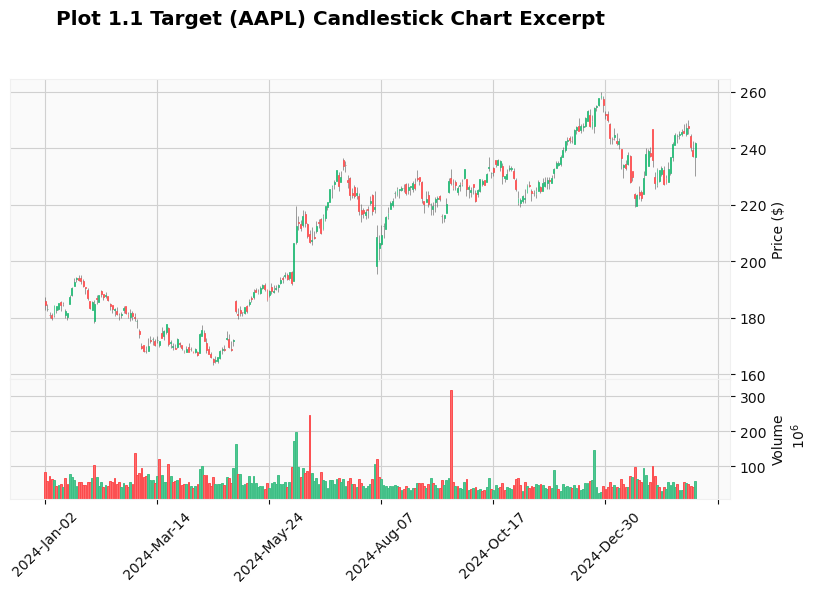

In [13]:
### Plot 1.1 Target (AAPL) Candlestick Chart Excerpt

# Filter AAPL columns and date range
plot_df = df[['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Volume']].copy()
plot_df.index = pd.to_datetime(df.index)

# Filter data from 2023 to present
plot_df = plot_df.loc[plot_df.index >= '2024-01-01']

# Rename columns to match mplfinance's expected format
plot_df.rename(columns={
    'AAPL_Open': 'Open',
    'AAPL_High': 'High',
    'AAPL_Low': 'Low',
    'AAPL_Close': 'Close',
    'AAPL_Volume': 'Volume'
}, inplace=True)

# Create Chart
mpf.plot(
    plot_df,
    type='candle',               
    volume=True,                 
    style='yahoo',               
    title='Plot 1.1 Target (AAPL) Candlestick Chart Excerpt',
    ylabel='Price ($)',
    ylabel_lower='Volume',
    figsize=(10, 6)
)

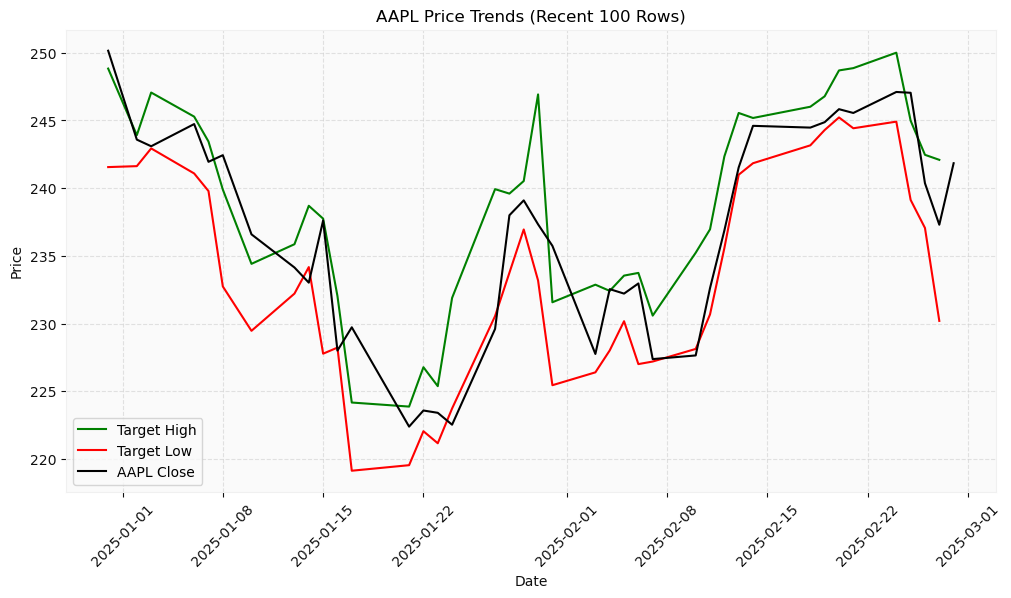

In [14]:
### Plot 1.2 Target (AAPL) Next Day High Low
plot_df = df.copy()

# Define Targets - Max High and Min Low over next 1 periods
plot_df['target_high'] = plot_df['AAPL_High'].shift(-1)
plot_df['target_low'] = plot_df['AAPL_Low'].shift(-1)

# Select the most recent 100 rows
plot_df_recent = plot_df.tail(40)

# Plot target_high, target_low, and AAPL_Close
plt.figure(figsize=(12,6))

plt.plot(plot_df_recent.index, plot_df_recent['target_high'], color='green', label='Target High')
plt.plot(plot_df_recent.index, plot_df_recent['target_low'], color='red', label='Target Low')
plt.plot(plot_df_recent.index, plot_df_recent['AAPL_Close'], color='black', label='AAPL Close')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Price Trends (Recent 100 Rows)')

# Add legend
plt.legend()

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


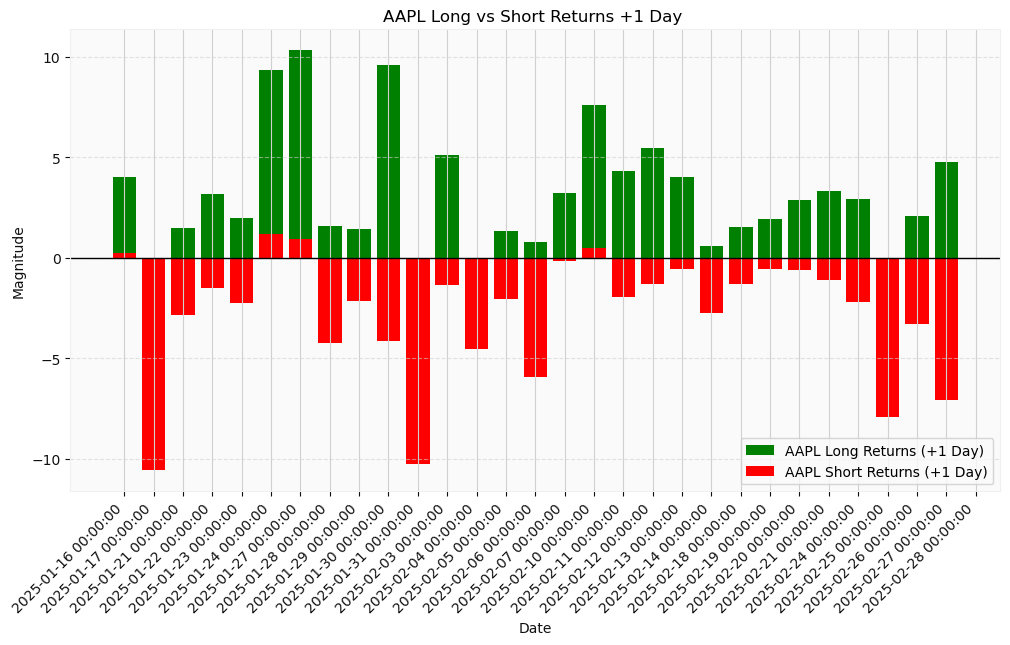

In [15]:
### Plot 1.3 Defined Model Targets - AAPL Long Returns (+1 Day) and AAPL Short Returns (+1 Day)
plot_df['target_long_returns'] = plot_df['target_high'] - plot_df['AAPL_Close']
plot_df['target_short_returns'] = plot_df['target_low'] - plot_df['AAPL_Close']

# Select the most recent 30 rows (optional, remove if full dataset is needed)
plot_df_recent = plot_df.tail(30)

# Set figure size
plt.figure(figsize=(12,6))

# X-axis positions
x = np.arange(len(plot_df_recent))

# Plot bars where target_high_normal is always positive, target_low_normal is always negative
plt.bar(x, plot_df_recent['target_long_returns'], color='green', label='AAPL Long Returns (+1 Day)')
plt.bar(x, plot_df_recent['target_short_returns'], color='red', label='AAPL Short Returns (+1 Day)')

# Set x-ticks as date values
plt.xticks(x, plot_df_recent.index, rotation=45, ha='right')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.title('AAPL Long vs Short Returns +1 Day ')

# Add legend
plt.legend()

# Horizontal line at y=0 for clarity
plt.axhline(0, color='black', linewidth=1)

# Show grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Show the plot
plt.show()


In [16]:
plot_df[['target_high', 'target_low', 'target_long_returns', 'target_short_returns']].describe()

,target_high,target_low,target_long_returns,target_short_returns
count,4315.000000,4315.000000,4315.000000,4315.000000
mean,62.291096,61.018329,0.658494,-0.614273
std,67.363498,66.018047,1.366007,1.437643
min,2.467675,2.353319,-6.338693,-23.780074
25%,13.408958,13.169976,0.060942,-0.647333
50%,27.774662,27.357541,0.204654,-0.164011
75%,118.528332,115.815428,0.725393,-0.020463
max,259.814335,257.347047,13.992978,9.584759


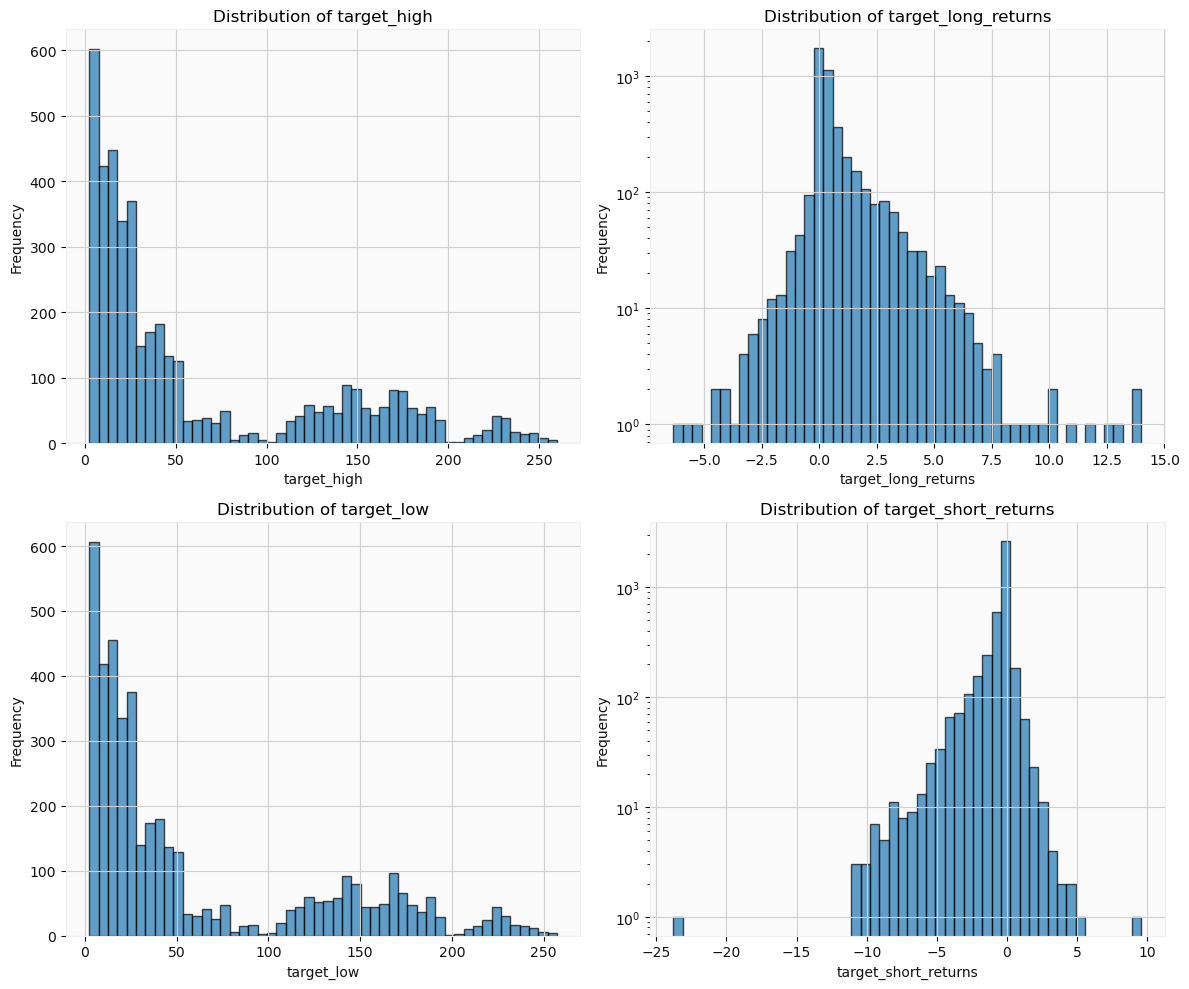

In [17]:
### Plot 1.4 Distribution of Target High and Low vs Long Returns and Short Returns 

# Define columns to plot and which should use a log scale
columns_to_plot = ['target_high', 'target_long_returns', 'target_low', 'target_short_returns']
log_scale_columns = ['target_long_returns', 'target_short_returns']

# Create a 2x2 subplot layout for quadrant-style display
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define subplot positions in a quadrant layout
subplot_positions = {
    'target_high': (0, 0),  # Top Left
    'target_long_returns': (0, 1),  # Top Right
    'target_low': (1, 0),  # Bottom Left
    'target_short_returns': (1, 1)  # Bottom Right
}

# Generate histograms in their respective quadrants
for col in columns_to_plot:
    row, col_index = subplot_positions[col]
    ax = axes[row, col_index]
    ax.hist(plot_df[col], bins=50, alpha=0.7, edgecolor='black', log=(col in log_scale_columns))
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# **Feature Engineering and Scaling**

### All Features High (target_long_returns)

Feature 1: 'AAPL_High' original column from AAPL data.

Feature 2: 'AAPL_Close' original column from AAPL data.

Feature 3: 'vwap_high1' created using AVWAP function, AAPL data ('high', 'low', and 'volume), using an anchor length of 20 periods and an average true range (atr) window of 20 periods.

Feature 4: 'vwap_high_band1' created using AVWAP function, AAPL data ('high', 'low', and 'volume), using an anchor length of 20 periods and an average true range (atr) window of 20 periods.

Feature 5: 'vwap_high2' created using AVWAP function, AAPL data ('high', 'low', and 'volume), using an anchor length of 50 periods and an average true range (atr) window of 50 periods.

Feature 6: 'vwap_high_band2' created using AVWAP function, AAPL data ('high', 'low', and 'volume), using an anchor length of 50 periods and an average true range (atr) window of 50 periods.

Feature 7: 'spy_vwap_high1' created using AVWAP function, SPY data ('high', 'low', and 'volume), using an anchor length of 10 periods and an average true range (atr) window of 20 periods.

Feature 8: 'spy_vwap_high_band1' created using AVWAP function, SPY data ('high', 'low', and 'volume), using an anchor length of 10 periods and an average true range (atr) window of 20 periods.

Feature 9: 'qqq_vwap_high1' created using AVWAP function, QQQ data ('high', 'low', and 'volume), using an anchor length of 10 periods and an average true range (atr) window of 20 periods.

Feature 10: 'qqq_vwap_high_band1' created using AVWAP function, QQQ data ('high', 'low', and 'volume), using an anchor length of 10 periods and an average true range (atr) window of 20 periods.

Feature 11: 'DX-Y.NYB_Close_20MA' created using a 20 period simple moving average of DX-Y.NYB_Close.

Feature 12: 'DX-Y.NYB_Close_50MA' created using a 50 period simple moving average of DX-Y.NYB_Close.

### All Features Low (target_short_returns)

Feature 1: 'AAPL_Low' original column from AAPL data.

Feature 2: 'AAPL_Close' original column from AAPL data.

Feature 3: 'vwap_low1' created using AVWAP function, AAPL data ('high', 'low', and 'volume), using an anchor length of 20 periods and an average true range (atr) window of 20 periods.

Feature 4: 'vwap_low_band1' created using AVWAP function, AAPL data ('high', 'low', and 'volume), using an anchor length of 20 periods and an average true range (atr) window of 20 periods.

Feature 5: 'vwap_low2' created using AVWAP function, AAPL data ('high', 'low', and 'volume), using an anchor length of 50 periods and an average true range (atr) window of 50 periods.

Feature 6: 'vwap_low_band2' created using AVWAP function, AAPL data ('high', 'low', and 'volume), using an anchor length of 50 periods and an average true range (atr) window of 50 periods.

Feature 7: 'spy_vwap_low1' created using AVWAP function, SPY data ('high', 'low', and 'volume), using an anchor length of 10 periods and an average true range (atr) window of 20 periods.

FEature 8: 'spy_vwap_low_band1' created using AVWAP function, SPY data ('high', 'low', and 'volume), using an anchor length of 10 periods and an average true range (atr) window of 20 periods.

Feature 9: 'qqq_vwap_low1' created using AVWAP function, QQQ data ('high', 'low', and 'volume), using an anchor length of 10 periods and an average true range (atr) window of 20 periods.

Feature 10: 'qqq_vwap_low_band1' created using AVWAP function, QQQ data ('high', 'low', and 'volume), using an anchor length of 10 periods and an average true range (atr) window of 20 periods.

Feature 11: 'DX-Y.NYB_Close_20MA' created using a 20 period simple moving average of DX-Y.NYB_Close.

Feature 12: 'DX-Y.NYB_Close_50MA' created using a 50 period simple moving average of DX-Y.NYB_Close.

### Feature Scaling

RobustScaler is used instead of StandardScaler or MinMaxScaler because the dataset contains highly volatile, unbounded features on different scales, with potential outliers. By scaling based on the interquartile range (IQR) rather than the mean and standard deviation or min/max values, RobustScaler minimizes the impact of extreme fluctuations, ensuring a more stable transformation.

In [19]:
# Create df to store features
feature_df = df.copy()

# Function to create VWAP features, using symbol, period, and average true range (atr) window
class CustomAVWAP:
    def __init__(self, period, atr_window):
        self.period = period
        self.atr_window = atr_window
        self.vwap_high = 0
        self.vwap_low = 0
        self.vwap_high_band = 0
        self.vwap_low_band = 0
        self.highest_volume = 0
        self.anchor_index = None
        self.high_price_vol_queue = deque(maxlen=period)
        self.low_price_vol_queue = deque(maxlen=period)
        self.volume_queue = deque(maxlen=period)
        self.high_price_queue = deque(maxlen=period)
        self.low_price_queue = deque(maxlen=period)
        self.close_price_queue = deque(maxlen=period) 
        self.true_range_queue = deque(maxlen=atr_window) 

    def update(self, high, low, close, volume):
        # Calculate high * volume and low * volume
        high_price_vol = high * volume
        low_price_vol = low * volume

        # Add to the rolling windows
        self.high_price_vol_queue.appendleft(high_price_vol)
        self.low_price_vol_queue.appendleft(low_price_vol)
        self.volume_queue.appendleft(volume)
        self.high_price_queue.appendleft(high)
        self.low_price_queue.appendleft(low)
        self.close_price_queue.appendleft(close)

        # Identify the highest volume and set it as the anchor point
        if volume > self.highest_volume:
            self.highest_volume = volume
            self.anchor_index = 0

        # Calculate cumulative volume, high * volume, and low * volume
        cum_high_price_vol = sum(self.high_price_vol_queue)
        cum_low_price_vol = sum(self.low_price_vol_queue)
        cum_volume = sum(self.volume_queue)

        # Calculate True Range (TR)
        if len(self.close_price_queue) > 1:
            prev_close = self.close_price_queue[1] 
            tr = max(
                high - low,  
                abs(high - prev_close), 
                abs(low - prev_close)  
            )
            self.true_range_queue.appendleft(tr) 

        # Calculate ATR over the last atr_window periods
        if len(self.true_range_queue) >= self.atr_window:
            atr = np.mean(self.true_range_queue)
        else:
            atr = 0

        # Calculate VWAP based on the anchored data
        if cum_volume > 0:
            self.vwap_high = cum_high_price_vol / cum_volume
            self.vwap_low = cum_low_price_vol / cum_volume

            # Update the bands using ATR
            self.vwap_high_band = self.vwap_high + atr*3
            self.vwap_low_band = self.vwap_low - atr*3

        else:
            self.vwap_high = 0
            self.vwap_low = 0
            self.vwap_high_band = 0
            self.vwap_low_band = 0

        # Return the updated VWAP values and bands
        return self.vwap_high, self.vwap_low, self.vwap_high_band, self.vwap_low_band

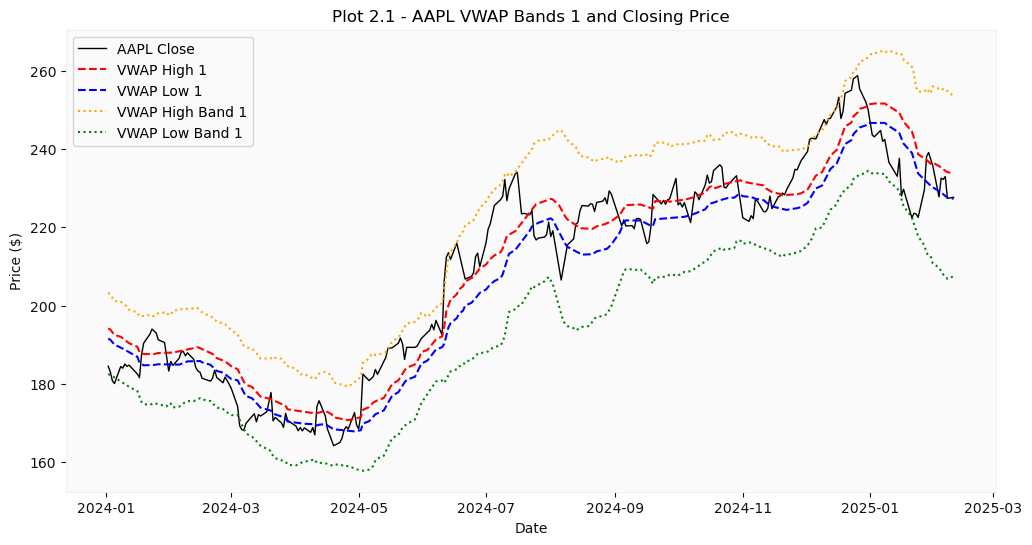

In [20]:
# Initialize the CustomAVWAP with a period
avwap_calculator = CustomAVWAP(period=20, atr_window=20) 

# Create new columns for VWAP High and VWAP Low
feature_df['vwap_high1'] = 0.0
feature_df['vwap_low1'] = 0.0
feature_df['vwap_high_band1'] = 0.0
feature_df['vwap_low_band1'] = 0.0

# Loop through the DataFrame and update AVWAP
for i, row in df.iterrows():
    vwap_high, vwap_low, vwap_high_band, vwap_low_band = avwap_calculator.update(
        row['AAPL_High'], row['AAPL_Low'], row['AAPL_Close'], row['AAPL_Volume'] 
    )
    feature_df.at[i, 'vwap_high1'] = vwap_high
    feature_df.at[i, 'vwap_low1'] = vwap_low
    feature_df.at[i, 'vwap_high_band1'] = vwap_high_band
    feature_df.at[i, 'vwap_low_band1'] = vwap_low_band

# Ensure index is datetime for proper plotting
feature_df.index = pd.to_datetime(feature_df.index)

# Filter data for the desired date range
start_date = '2024-01-01'
end_date = '2025-02-10'
feature_df_filtered = feature_df.loc[(feature_df.index >= start_date) & (feature_df.index <= end_date)]

# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(feature_df_filtered.index, feature_df_filtered['AAPL_Close'], label='AAPL Close', color='black', linewidth=1)

# Plot VWAP High and Low
plt.plot(feature_df_filtered.index, feature_df_filtered['vwap_high1'], label='VWAP High 1', color='red', linestyle='dashed')
plt.plot(feature_df_filtered.index, feature_df_filtered['vwap_low1'], label='VWAP Low 1', color='blue', linestyle='dashed')

# Plot VWAP High & Low Bands
plt.plot(feature_df_filtered.index, feature_df_filtered['vwap_high_band1'], label='VWAP High Band 1', color='orange', linestyle='dotted')
plt.plot(feature_df_filtered.index, feature_df_filtered['vwap_low_band1'], label='VWAP Low Band 1', color='green', linestyle='dotted')

# Labels and Legend
plt.title('Plot 2.1 - AAPL VWAP Bands 1 and Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Show the Plot
plt.show()

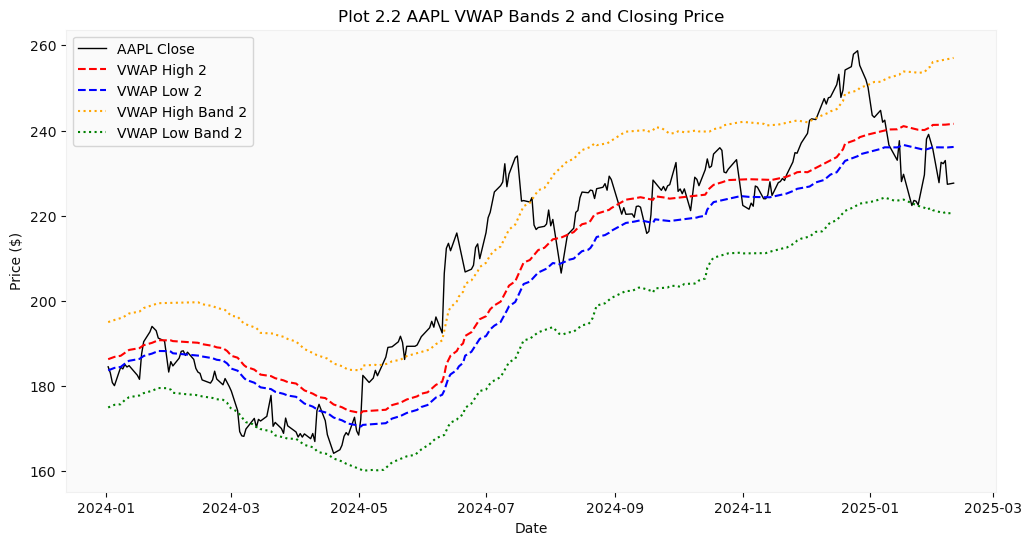

In [21]:
# Initialize the CustomAVWAP with a period
avwap_calculator = CustomAVWAP(period=50, atr_window=50) 

# Create new columns for VWAP High and VWAP Low
feature_df['vwap_high2'] = 0.0
feature_df['vwap_low2'] = 0.0
feature_df['vwap_high_band2'] = 0.0
feature_df['vwap_low_band2'] = 0.0

# Loop through the DataFrame and update AVWAP
for i, row in df.iterrows():
    vwap_high, vwap_low, vwap_high_band, vwap_low_band = avwap_calculator.update(
        row['AAPL_High'], row['AAPL_Low'], row['AAPL_Close'], row['AAPL_Volume'] 
    )
    feature_df.at[i, 'vwap_high2'] = vwap_high
    feature_df.at[i, 'vwap_low2'] = vwap_low
    feature_df.at[i, 'vwap_high_band2'] = vwap_high_band
    feature_df.at[i, 'vwap_low_band2'] = vwap_low_band

# Ensure index is datetime for proper plotting
feature_df.index = pd.to_datetime(feature_df.index)

# Filter data for the desired date range
start_date = '2024-01-01'
end_date = '2025-02-10'
feature_df_filtered = feature_df.loc[(feature_df.index >= start_date) & (feature_df.index <= end_date)]

# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(feature_df_filtered.index, feature_df_filtered['AAPL_Close'], label='AAPL Close', color='black', linewidth=1)

# Plot VWAP High and Low
plt.plot(feature_df_filtered.index, feature_df_filtered['vwap_high2'], label='VWAP High 2', color='red', linestyle='dashed')
plt.plot(feature_df_filtered.index, feature_df_filtered['vwap_low2'], label='VWAP Low 2', color='blue', linestyle='dashed')

# Plot VWAP High & Low Bands
plt.plot(feature_df_filtered.index, feature_df_filtered['vwap_high_band2'], label='VWAP High Band 2', color='orange', linestyle='dotted')
plt.plot(feature_df_filtered.index, feature_df_filtered['vwap_low_band2'], label='VWAP Low Band 2', color='green', linestyle='dotted')

# Labels and Legend
plt.title('Plot 2.2 AAPL VWAP Bands 2 and Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Show the Plot
plt.show()

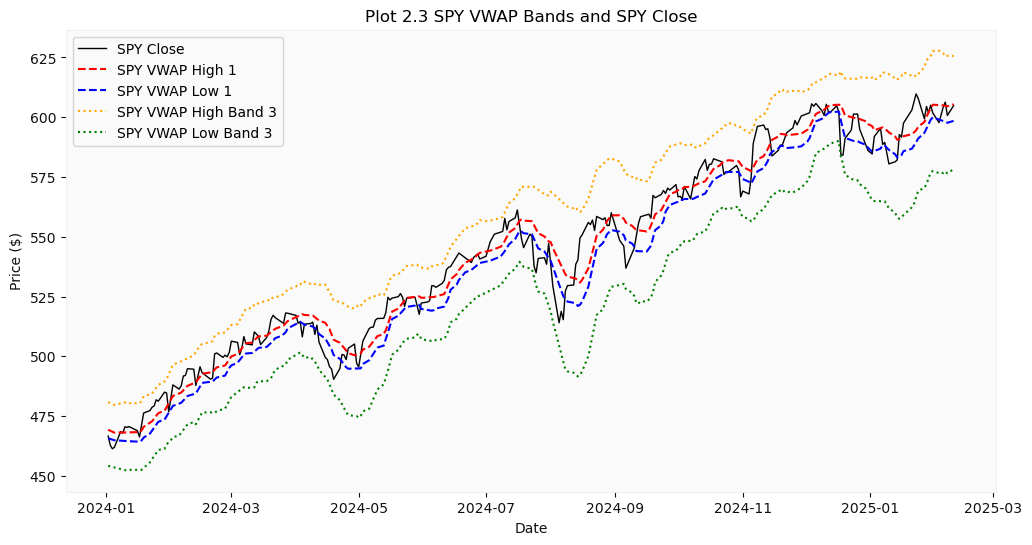

In [22]:
# Initialize the CustomAVWAP with a period
avwap_calculator = CustomAVWAP(period=10, atr_window=20) 

# Create new columns for VWAP High and VWAP Low
feature_df['spy_vwap_high1'] = 0.0
feature_df['spy_vwap_low1'] = 0.0
feature_df['spy_vwap_high_band1'] = 0.0
feature_df['spy_vwap_low_band1'] = 0.0

# Loop through the DataFrame and update AVWAP
for i, row in df.iterrows():
    vwap_high, vwap_low, vwap_high_band, vwap_low_band = avwap_calculator.update(
        row['SPY_High'], row['SPY_Low'], row['SPY_Close'], row['SPY_Volume']  # Pass 'close' price as well
    )
    feature_df.at[i, 'spy_vwap_high1'] = vwap_high
    feature_df.at[i, 'spy_vwap_low1'] = vwap_low
    feature_df.at[i, 'spy_vwap_high_band1'] = vwap_high_band
    feature_df.at[i, 'spy_vwap_low_band1'] = vwap_low_band

# Ensure index is datetime for proper plotting
feature_df.index = pd.to_datetime(feature_df.index)

# Filter data for the desired date range
start_date = '2024-01-01'
end_date = '2025-02-10'
feature_df_filtered = feature_df.loc[(feature_df.index >= start_date) & (feature_df.index <= end_date)]

# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(feature_df_filtered.index, feature_df_filtered['SPY_Close'], label='SPY Close', color='black', linewidth=1)

# Plot VWAP High and Low
plt.plot(feature_df_filtered.index, feature_df_filtered['spy_vwap_high1'], label='SPY VWAP High 1', color='red', linestyle='dashed')
plt.plot(feature_df_filtered.index, feature_df_filtered['spy_vwap_low1'], label='SPY VWAP Low 1', color='blue', linestyle='dashed')

# Plot VWAP High & Low Bands
plt.plot(feature_df_filtered.index, feature_df_filtered['spy_vwap_high_band1'], label='SPY VWAP High Band 3', color='orange', linestyle='dotted')
plt.plot(feature_df_filtered.index, feature_df_filtered['spy_vwap_low_band1'], label='SPY VWAP Low Band 3', color='green', linestyle='dotted')

# Labels and Legend
plt.title('Plot 2.3 SPY VWAP Bands and SPY Close')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Show the Plot
plt.show()

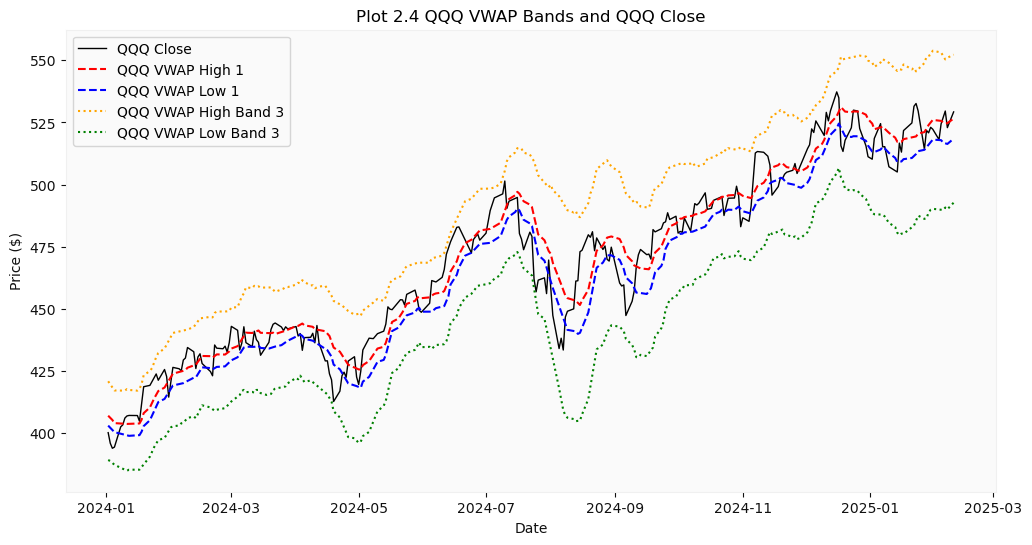

In [23]:
# Initialize the CustomAVWAP with a period
avwap_calculator = CustomAVWAP(period=10, atr_window=20) 

# Create new columns for VWAP High and VWAP Low
feature_df['qqq_vwap_high1'] = 0.0
feature_df['qqq_vwap_low1'] = 0.0
feature_df['qqq_vwap_high_band1'] = 0.0
feature_df['qqq_vwap_low_band1'] = 0.0

# Loop through the DataFrame and update AVWAP
for i, row in df.iterrows():
    vwap_high, vwap_low, vwap_high_band, vwap_low_band = avwap_calculator.update(
        row['QQQ_High'], row['QQQ_Low'], row['QQQ_Close'], row['QQQ_Volume']  # Pass 'close' price as well
    )
    feature_df.at[i, 'qqq_vwap_high1'] = vwap_high
    feature_df.at[i, 'qqq_vwap_low1'] = vwap_low
    feature_df.at[i, 'qqq_vwap_high_band1'] = vwap_high_band
    feature_df.at[i, 'qqq_vwap_low_band1'] = vwap_low_band

# Ensure index is datetime for proper plotting
feature_df.index = pd.to_datetime(feature_df.index)

# Filter data for the desired date range
start_date = '2024-01-01'
end_date = '2025-02-10'
feature_df_filtered = feature_df.loc[(feature_df.index >= start_date) & (feature_df.index <= end_date)]

# Plot the Closing Price
plt.figure(figsize=(12, 6))
plt.plot(feature_df_filtered.index, feature_df_filtered['QQQ_Close'], label='QQQ Close', color='black', linewidth=1)

# Plot VWAP High and Low
plt.plot(feature_df_filtered.index, feature_df_filtered['qqq_vwap_high1'], label='QQQ VWAP High 1', color='red', linestyle='dashed')
plt.plot(feature_df_filtered.index, feature_df_filtered['qqq_vwap_low1'], label='QQQ VWAP Low 1', color='blue', linestyle='dashed')

# Plot VWAP High & Low Bands
plt.plot(feature_df_filtered.index, feature_df_filtered['qqq_vwap_high_band1'], label='QQQ VWAP High Band 3', color='orange', linestyle='dotted')
plt.plot(feature_df_filtered.index, feature_df_filtered['qqq_vwap_low_band1'], label='QQQ VWAP Low Band 3', color='green', linestyle='dotted')

# Labels and Legend
plt.title('Plot 2.4 QQQ VWAP Bands and QQQ Close')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Show the Plot
plt.show()

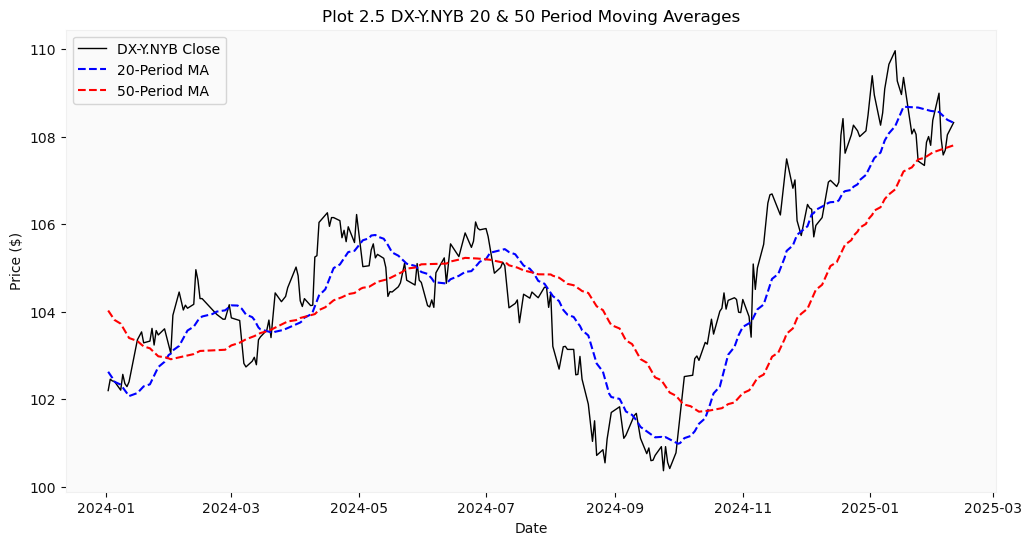

In [24]:
# Ensure the index is datetime for proper plotting
feature_df.index = pd.to_datetime(feature_df.index)

# Calculate the 20-period and 50-period moving averages
feature_df['DX-Y.NYB_Close_20MA'] = feature_df['DX-Y.NYB_Close'].rolling(window=20).mean()
feature_df['DX-Y.NYB_Close_50MA'] = feature_df['DX-Y.NYB_Close'].rolling(window=50).mean()

feature_df.drop(index=feature_df.index[:50], inplace=True)

# Filter data for the desired date range
start_date = '2024-01-01'
end_date = '2025-02-10'
feature_df_filtered = feature_df.loc[(feature_df.index >= start_date) & (feature_df.index <= end_date)]

# Plot the Closing Price and Moving Averages
plt.figure(figsize=(12, 6))

# Plot the DX-Y.NYB Close price
plt.plot(feature_df_filtered.index, feature_df_filtered['DX-Y.NYB_Close'], label='DX-Y.NYB Close', color='black', linewidth=1)

# Plot the 20-period moving average
plt.plot(feature_df_filtered.index, feature_df_filtered['DX-Y.NYB_Close_20MA'], label='20-Period MA', color='blue', linestyle='dashed')

# Plot the 50-period moving average
plt.plot(feature_df_filtered.index, feature_df_filtered['DX-Y.NYB_Close_50MA'], label='50-Period MA', color='red', linestyle='dashed')

# Formatting the plot
plt.title('Plot 2.5 DX-Y.NYB 20 & 50 Period Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [25]:
# Replace inf values with NaN so they can be dropped
feature_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop all rows that contain NaN values (which includes former inf values)
feature_df.dropna(inplace=True)

# Reset index after dropping
feature_df.reset_index(drop=True, inplace=True)

# Confirm removal check columns
#print("All NaNs and infinite values have been removed from feature_df.")
#print(feature_df.columns.tolist())
#print(f"Remaining rows: {len(feature_df)}")

In [26]:
#Defined Model Targets - AAPL Long Returns (+1 Day) and AAPL Short Returns (+1 Day)

feature_df['target_high'] = feature_df['AAPL_High'].shift(-1)
feature_df['target_low'] = feature_df['AAPL_Low'].shift(-1)

feature_df['target_long_returns'] = feature_df['target_high'] - feature_df['AAPL_Close']
feature_df['target_short_returns'] = feature_df['target_low'] - feature_df['AAPL_Close']

In [27]:
# Transform Features

all_features_high = feature_df[['AAPL_High', 'AAPL_Close', 'vwap_high1', 'vwap_high_band1', 'vwap_high2', 'vwap_high_band2', 'spy_vwap_high1', 'spy_vwap_high_band1', 
                'qqq_vwap_high1', 'qqq_vwap_high_band1', 'DX-Y.NYB_Close_20MA', 'DX-Y.NYB_Close_50MA']]

all_features_low = feature_df[['AAPL_Low','AAPL_Close', 'vwap_low1', 'vwap_low_band1', 'vwap_low2', 'vwap_low_band2', 'spy_vwap_low1', 'spy_vwap_low_band1', 
               'qqq_vwap_low1', 'qqq_vwap_low_band1', 'DX-Y.NYB_Close_20MA', 'DX-Y.NYB_Close_50MA']]


# Create the transformer for scaling
transformer = make_column_transformer(
    (RobustScaler(), make_column_selector(dtype_include=['float64', 'int32'])),  
    remainder='passthrough'
)

# Ensure column names are strings
X_low = all_features_low.copy()
X_high = all_features_high.copy()
X_low.columns = [str(col) for col in X_low.columns]
X_high.columns = [str(col) for col in X_high.columns]

# Create the scaler objects
scaler_high = RobustScaler() 
scaler_low = RobustScaler()  

# Fit the scalers separately for high and low features
X_high_transformed = scaler_high.fit_transform(X_high)
X_low_transformed = scaler_low.fit_transform(X_low)

# Convert transformed arrays back to DataFrames with correct column names
X_high_transformed = pd.DataFrame(X_high_transformed, columns=X_high.columns)
X_low_transformed = pd.DataFrame(X_low_transformed, columns=X_low.columns)

# Verify the transformed DataFrames
print("X_low_transformed columns:", list(X_low_transformed.columns))
print("X_high_transformed columns:", list(X_high_transformed.columns))

#X_low_transformed.head()
#X_high_transformed.head()

X_low_transformed columns: ['AAPL_Low', 'AAPL_Close', 'vwap_low1', 'vwap_low_band1', 'vwap_low2', 'vwap_low_band2', 'spy_vwap_low1', 'spy_vwap_low_band1', 'qqq_vwap_low1', 'qqq_vwap_low_band1', 'DX-Y.NYB_Close_20MA', 'DX-Y.NYB_Close_50MA']
X_high_transformed columns: ['AAPL_High', 'AAPL_Close', 'vwap_high1', 'vwap_high_band1', 'vwap_high2', 'vwap_high_band2', 'spy_vwap_high1', 'spy_vwap_high_band1', 'qqq_vwap_high1', 'qqq_vwap_high_band1', 'DX-Y.NYB_Close_20MA', 'DX-Y.NYB_Close_50MA']


# **Model Generation and Optimization**

### Model 1: Random Forest

### Model 2: XGBoost

### Model 3: LGBM

In [29]:
# Random Forest
rf_df = feature_df.copy()

y1 = rf_df['target_long_returns']
y2 = rf_df['target_short_returns']

# Reserve the last 1% of rows for simulated live testing 
live_test_size = int(0.01 * len(rf_df))  

# Split the dataset into training + validation, and live test set
X_live_y1 = X_high_transformed.iloc[-live_test_size:].reset_index(drop=True)
X_live_y2 = X_low_transformed.iloc[-live_test_size:].reset_index(drop=True)

y_live_y1 = y1.iloc[-live_test_size:].reset_index(drop=True)
y_live_y2 = y2.iloc[-live_test_size:].reset_index(drop=True)

# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

y1_train_data = y1.iloc[:-live_test_size].reset_index(drop=True)
y2_train_data = y2.iloc[:-live_test_size].reset_index(drop=True)

# Define parameter search space
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

n_splits = 10
test_size = int(len(X_train_data_y1) / n_splits)  

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Initialize Regressors
rf_y1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_y2 = RandomForestRegressor(n_estimators=100, random_state=42)

# RandomizedSearch for y1
random_search_y1 = RandomizedSearchCV(
    estimator=rf_y1,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_y1.fit(X_train_data_y1, y1_train_data)
print("Best Params for y1:", random_search_y1.best_params_)

# Randomized search for y2
random_search_y2 = RandomizedSearchCV(
    estimator=rf_y2,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_y2.fit(X_train_data_y2, y2_train_data)

random_search_y2.fit(X_train_data_y2, y2_train_data)
print("Best Params for y2:", random_search_y2.best_params_)

# Best params
best_params_y1 = random_search_y1.best_params_
best_params_y2 = random_search_y2.best_params_

# Prepare params for WFO loops
params_y1 = {**best_params_y1}  
params_y2 = {**best_params_y2} 

# Initialize models and metric trackers
mae_progress_y1, mse_progress_y1 = [], []
mae_progress_y2, mse_progress_y2 = [], []
predictions_y1_all, predictions_y2_all = [], []

for train_index, test_index in tscv.split(X_train_data_y1):
    X_train_y1, X_test_y1 = X_train_data_y1.iloc[train_index], X_train_data_y1.iloc[test_index]
    y_train_y1, y_test_y1 = y1_train_data.iloc[train_index], y1_train_data.iloc[test_index]

    X_train_y2, X_test_y2 = X_train_data_y2.iloc[train_index], X_train_data_y2.iloc[test_index]
    y_train_y2, y_test_y2 = y2_train_data.iloc[train_index], y2_train_data.iloc[test_index]

    rf_model_y1 = RandomForestRegressor(**params_y1)
    rf_model_y1.fit(X_train_y1, y_train_y1)

    rf_model_y2 = RandomForestRegressor(**params_y2)
    rf_model_y2.fit(X_train_y2, y_train_y2)

    # Predictions
    predictions_y1 = rf_model_y1.predict(X_test_y1)
    predictions_y2 = rf_model_y2.predict(X_test_y2)

    # Store predictions
    predictions_y1_all.extend(predictions_y1)
    predictions_y2_all.extend(predictions_y2)

    # Calculate metrics for y1
    mae_y1 = mean_absolute_error(y_test_y1, predictions_y1)
    mse_y1 = mean_squared_error(y_test_y1, predictions_y1)
    mae_progress_y1.append(mae_y1)
    mse_progress_y1.append(mse_y1)

    # Calculate metrics for y2
    mae_y2 = mean_absolute_error(y_test_y2, predictions_y2)
    mse_y2 = mean_squared_error(y_test_y2, predictions_y2)
    mae_progress_y2.append(mae_y2)
    mse_progress_y2.append(mse_y2)

    print(f"MAE y1: {mae_y1:.4f}, MSE y1: {mse_y1:.4f} | MAE y2: {mae_y2:.4f}, MSE y2: {mse_y2:.4f}")

print(f"Best MAE for y1: {min(mae_progress_y1):.4f}, Best MSE for y1: {min(mse_progress_y1):.4f}")
print(f"Best MAE for y2: {min(mae_progress_y2):.4f}, Best MSE for y2: {min(mse_progress_y2):.4f}")

print(f"Avg MAE for y1: {np.mean(mae_progress_y1):.4f}, Avg MSE for y1: {np.mean(mse_progress_y1):.4f}")
print(f"Avg MAE for y2: {np.mean(mae_progress_y2):.4f}, Avg MSE for y2: {np.mean(mse_progress_y2):.4f}")

print("\nFinal Best Parameters Used for WFO:")
print("Best Params for y1:", best_params_y1)
print("Best Params for y2:", best_params_y2)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best Params for y1: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3}
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best Params for y2: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 3}
MAE y1: 0.0676, MSE y1: 0.0071 | MAE y2: 0.0691, MSE y2: 0.0103
MAE y1: 0.0700, MSE y1: 0.0097 | MAE y2: 0.1011, MSE y2: 0.0218
MAE y1: 0.1601, MSE y1: 0.0540 | MAE y2: 0.1717, MSE y2: 0.0623
MAE y1: 0.1272, MSE y1: 0.0366 | MAE y2: 0.1698, MSE y2: 0.0547
MAE y1: 0.2220, MSE y1: 0.1012 | MAE y2: 0.2537, MSE y2: 0.1329
MAE y1: 0.2512, MSE y1: 0.1395 | MAE y2: 0.3280, MSE y2: 0.1668
MAE y1: 0.4399, MSE y1: 0.4125 | MAE y2: 0.5480, MSE y2: 0.5352
MAE y1: 1.3729, MSE y1: 3.8745 | MAE y2: 1.4039, MSE y2: 4.1827
MAE y1: 1.5899, MSE y1: 4.7063 | MAE y2:

In [30]:
# XGBoost
xgboost_df = feature_df.copy()

y1 = xgboost_df['target_long_returns']
y2 = xgboost_df['target_short_returns']

# Reserve the last 1% of rows for simulated live testing 
live_test_size = int(0.01 * len(xgboost_df))  

# Split the dataset into training + validation, and live test set
X_live_y1 = X_high_transformed.iloc[-live_test_size:].reset_index(drop=True)
X_live_y2 = X_low_transformed.iloc[-live_test_size:].reset_index(drop=True)

y_live_y1 = y1.iloc[-live_test_size:].reset_index(drop=True)
y_live_y2 = y2.iloc[-live_test_size:].reset_index(drop=True)

# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

y1_train_data = y1.iloc[:-live_test_size].reset_index(drop=True)
y2_train_data = y2.iloc[:-live_test_size].reset_index(drop=True)

# Define parameter search space
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 1.0], 
    'reg_lambda': [0, 0.1, 1.0]  
}

n_splits = 10
test_size = int(len(X_train_data_y1) / n_splits)  

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Initialize Boost Models
xgb_y1 = XGBRegressor(objective='reg:squarederror')
xgb_y2 = XGBRegressor(objective='reg:squarederror')

# RandomizedSearch for y1
random_search_y1 = RandomizedSearchCV(
    estimator=xgb_y1,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_y1.fit(X_train_data_y1, y1_train_data)

print("Best Params for y1:", random_search_y1.best_params_)

# Randomized search for y2
random_search_y2 = RandomizedSearchCV(
    estimator=xgb_y2,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_y2.fit(X_train_data_y2, y2_train_data)

print("Best Params for y2:", random_search_y2.best_params_)

# Best params
best_params_y1 = random_search_y1.best_params_
best_params_y2 = random_search_y2.best_params_

# Prepare params for WFO loops
params_y1 = {**best_params_y1}  
params_y2 = {**best_params_y2}  

# Initialize models and metric trackers
mae_progress_y1, mse_progress_y1 = [], []
mae_progress_y2, mse_progress_y2 = [], []
predictions_y1_all, predictions_y2_all = [], []

for train_index, test_index in tscv.split(X_train_data_y1):
    train_index = train_index

    X_train_y1, X_test_y1 = X_train_data_y1.iloc[train_index], X_train_data_y1.iloc[test_index]
    y_train_y1, y_test_y1 = y1_train_data.iloc[train_index], y1_train_data.iloc[test_index]

    X_train_y2, X_test_y2 = X_train_data_y2.iloc[train_index], X_train_data_y2.iloc[test_index]
    y_train_y2, y_test_y2 = y2_train_data.iloc[train_index], y2_train_data.iloc[test_index]

    xgb_model_y1 = XGBRegressor(**params_y1)
    xgb_model_y1.fit(X_train_y1, y_train_y1, eval_set=[(X_test_y1, y_test_y1)], verbose=False)

    xgb_model_y2 = XGBRegressor(**params_y2)
    xgb_model_y2.fit(X_train_y2, y_train_y2, eval_set=[(X_test_y2, y_test_y2)], verbose=False)

    # Predictions
    predictions_y1 = xgb_model_y1.predict(X_test_y1)
    predictions_y2 = xgb_model_y2.predict(X_test_y2)

    # Store predictions
    predictions_y1_all.extend(predictions_y1)
    predictions_y2_all.extend(predictions_y2)

    # Calculate metrics for y1
    mae_y1 = mean_absolute_error(y_test_y1, predictions_y1)
    mse_y1 = mean_squared_error(y_test_y1, predictions_y1)
    mae_progress_y1.append(mae_y1)
    mse_progress_y1.append(mse_y1)

    # Calculate metrics for y2
    mae_y2 = mean_absolute_error(y_test_y2, predictions_y2)
    mse_y2 = mean_squared_error(y_test_y2, predictions_y2)
    mae_progress_y2.append(mae_y2)
    mse_progress_y2.append(mse_y2)

    print(f"MAE y1: {mae_y1:.4f}, MSE y1: {mse_y1:.4f} | MAE y2: {mae_y2:.4f}, MSE y2: {mse_y2:.4f}")

print(f"Best MAE for y1: {min(mae_progress_y1):.4f}, Best MSE for y1: {min(mse_progress_y1):.4f}")
print(f"Best MAE for y2: {min(mae_progress_y2):.4f}, Best MSE for y2: {min(mse_progress_y2):.4f}")

print(f"Avg MAE for y1: {np.mean(mae_progress_y1):.4f}, Avg MSE for y1: {np.mean(mse_progress_y1):.4f}")
print(f"Avg MAE for y2: {np.mean(mae_progress_y2):.4f}, Avg MSE for y2: {np.mean(mse_progress_y2):.4f}")

print("\nFinal Best Parameters Used for WFO:")
print("Best Params for y1:", best_params_y1)
print("Best Params for y2:", best_params_y2)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best Params for y1: {'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best Params for y2: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
MAE y1: 0.0669, MSE y1: 0.0070 | MAE y2: 0.0686, MSE y2: 0.0101
MAE y1: 0.0700, MSE y1: 0.0098 | MAE y2: 0.0898, MSE y2: 0.0204
MAE y1: 0.1598, MSE y1: 0.0586 | MAE y2: 0.1752, MSE y2: 0.0647
MAE y1: 0.1647, MSE y1: 0.0541 | MAE y2: 0.1554, MSE y2: 0.0520
MAE y1: 0.2191, MSE y1: 0.1024 | MAE y2: 0.2493, MSE y2: 0.1336
MAE y1: 0.2540, MSE y1: 0.1533 | MAE y2: 0.2520, MSE y2: 0.1390
MAE y1: 0.4973, MSE y1: 0.4993 | MAE y2: 0.4865, MSE y2: 0.5254
MAE y1: 1.3524, MSE y1: 3.7621 | MAE y2: 1.4631, MSE y2: 4.4911
MAE y1: 1.5983, MSE y1: 4.8173 | MAE y2:

In [31]:
lgbm_df = feature_df.copy()

y1 = lgbm_df['target_long_returns']
y2 = lgbm_df['target_short_returns']

# Reserve the last 1% of rows for simulated live testing 
live_test_size = int(0.01 * len(lgbm_df))  

# Split the dataset into training + validation, and live test set
X_live_y1 = X_high_transformed.iloc[-live_test_size:].reset_index(drop=True)
X_live_y2 = X_low_transformed.iloc[-live_test_size:].reset_index(drop=True)

y_live_y1 = y1.iloc[-live_test_size:].reset_index(drop=True)
y_live_y2 = y2.iloc[-live_test_size:].reset_index(drop=True)

# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

y1_train_data = y1.iloc[:-live_test_size].reset_index(drop=True)
y2_train_data = y2.iloc[:-live_test_size].reset_index(drop=True)

# Define parameter search space
param_dist = {
    'num_leaves': [16, 32, 64],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_data_in_leaf': [10, 20, 30],
    'bagging_fraction': [0.7, 0.9],
    'feature_fraction': [0.7, 0.9],
    'lambda_l1': [0, 0.1, 1.0],
    'lambda_l2': [0, 0.1, 1.0],
}

# Time Series CV
n_splits = 10
test_size = int(len(X_train_data_y1) / n_splits)  

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Initialize LGBM regressors
lgbm_y1 = LGBMRegressor(objective='regression', metric='l2', boosting_type='gbdt')
lgbm_y2 = LGBMRegressor(objective='regression', metric='l2', boosting_type='gbdt')

# RandomizedSearch for y1
random_search_y1 = RandomizedSearchCV(
    estimator=lgbm_y1,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_y1.fit(X_train_data_y1, y1_train_data)
print("Best Params for y1:", random_search_y1.best_params_)

# Randomized search for y2
random_search_y2 = RandomizedSearchCV(
    estimator=lgbm_y2,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search_y2.fit(X_train_data_y2, y2_train_data)
print("Best Params for y2:", random_search_y2.best_params_)

# Best params
best_params_y1 = random_search_y1.best_params_
best_params_y2 = random_search_y2.best_params_

# Prepare params for WFO loops
params_y1 = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'learning_rate': best_params_y1['learning_rate'],
    **best_params_y1
}

params_y2 = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'learning_rate': best_params_y2['learning_rate'],
    **best_params_y2
}

# Initialize models and metric trackers
mae_progress_y1, mse_progress_y1 = [], []
mae_progress_y2, mse_progress_y2 = [], []
predictions_y1_all, predictions_y2_all = [], []

for train_index, test_index in tscv.split(X_train_data_y1):
    train_index = train_index

    X_train_y1, X_test_y1 = X_train_data_y1.iloc[train_index], X_train_data_y1.iloc[test_index]
    y_train_y1, y_test_y1 = y1_train_data.iloc[train_index], y1_train_data.iloc[test_index]

    X_train_y2, X_test_y2 = X_train_data_y2.iloc[train_index], X_train_data_y2.iloc[test_index]
    y_train_y2, y_test_y2 = y2_train_data.iloc[train_index], y2_train_data.iloc[test_index]

    lgbm_train_data_y1 = lgb.Dataset(X_train_y1, label=y_train_y1)
    lgbm_val_data_y1 = lgb.Dataset(X_test_y1, label=y_test_y1)

    lgbm_train_data_y2 = lgb.Dataset(X_train_y2, label=y_train_y2)
    lgbm_val_data_y2 = lgb.Dataset(X_test_y2, label=y_test_y2)

    lgbm_model_y1 = lgb.train(
        params_y1,
        lgbm_train_data_y1,
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
        valid_sets=[lgbm_train_data_y1, lgbm_val_data_y1],
        valid_names=['train_y1', 'valid_y1']        
    )

    lgbm_model_y2 = lgb.train(
        params_y2,
        lgbm_train_data_y2,
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
        valid_sets=[lgbm_train_data_y2, lgbm_val_data_y2],
        valid_names=['train_y2', 'valid_y2']      
    )

    # Predictions
    predictions_y1 = lgbm_model_y1.predict(X_test_y1)
    predictions_y2 = lgbm_model_y2.predict(X_test_y2)

    # Store predictions
    predictions_y1_all.extend(predictions_y1)
    predictions_y2_all.extend(predictions_y2)

    # Calculate metrics for y1
    mae_y1 = mean_absolute_error(y_test_y1, predictions_y1)
    mse_y1 = mean_squared_error(y_test_y1, predictions_y1)
    mae_progress_y1.append(mae_y1)
    mse_progress_y1.append(mse_y1)

    # Calculate metrics for y2
    mae_y2 = mean_absolute_error(y_test_y2, predictions_y2)
    mse_y2 = mean_squared_error(y_test_y2, predictions_y2)
    mae_progress_y2.append(mae_y2)
    mse_progress_y2.append(mse_y2)

    print(f"MAE y1: {mae_y1:.4f}, MSE y1: {mse_y1:.4f} | MAE y2: {mae_y2:.4f}, MSE y2: {mse_y2:.4f}")

print(f"Best MAE for y1: {min(mae_progress_y1):.4f}, Best MSE for y1: {min(mse_progress_y1):.4f}")
print(f"Best MAE for y2: {min(mae_progress_y2):.4f}, Best MSE for y2: {min(mse_progress_y2):.4f}")

print(f"Avg MAE for y1: {np.mean(mae_progress_y1):.4f}, Avg MSE for y1: {np.mean(mse_progress_y1):.4f}")
print(f"Avg MAE for y2: {np.mean(mae_progress_y2):.4f}, Avg MSE for y2: {np.mean(mse_progress_y2):.4f}")

print("\nFinal Best Parameters Used for WFO:")
print("Best Params for y1:", best_params_y1)
print("Best Params for y2:", best_params_y2)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warnin

# **Final Optimized Models**

### Model 1: Randomforrest

### Model 2: XGBoost

### Model 3: LGBM

In [127]:
# Create df to store eval metrics
eval_df = pd.DataFrame()

In [128]:
# Random Forrest Optimized Model
rf_df = feature_df.copy()

y1 = rf_df['target_long_returns']
y2 = rf_df['target_short_returns']

# Reserve the last 1% of rows for simulated live testing 
live_test_size = int(0.01 * len(rf_df))  

# Split the dataset into training + validation, and live test set
X_live_y1 = X_high_transformed.iloc[-live_test_size:].reset_index(drop=True)
X_live_y2 = X_low_transformed.iloc[-live_test_size:].reset_index(drop=True)

y_live_y1 = y1.iloc[-live_test_size:].reset_index(drop=True)
y_live_y2 = y2.iloc[-live_test_size:].reset_index(drop=True)

# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

y1_train_data = y1.iloc[:-live_test_size].reset_index(drop=True)
y2_train_data = y2.iloc[:-live_test_size].reset_index(drop=True)

# Initialize models and metric trackers
mae_progress_y1, mse_progress_y1 = [], []
mae_progress_y2, mse_progress_y2 = [], []
predictions_y1_all, predictions_y2_all = [], []

params_y1 = {
    'n_estimators': 200,  
    'max_depth': 3,  
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
}

params_y2 = {
    'n_estimators': 100,  
    'max_depth': 3,  
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
}

n_splits = 10
test_size = int(len(X_train_data_y1) / n_splits)  

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Prepare the dataset excluding y_live for y1 and y2
# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

# Initialize lists to store residuals for all WFO steps
residuals_y1_all = []
residuals_y2_all = []

for train_index, test_index in tscv.split(X_train_data_y1):
    train_index = np.arange(0, test_index[0])

    X_train_y1, X_test_y1 = X_train_data_y1.iloc[train_index], X_train_data_y1.iloc[test_index]
    y_train_y1, y_test_y1 = y1_train_data.iloc[train_index], y1_train_data.iloc[test_index]

    X_train_y2, X_test_y2 = X_train_data_y2.iloc[train_index], X_train_data_y2.iloc[test_index]
    y_train_y2, y_test_y2 = y2_train_data.iloc[train_index], y2_train_data.iloc[test_index]

    rf_model_y1 = RandomForestRegressor(**params_y1)
    rf_model_y1.fit(X_train_y1, y_train_y1)

    rf_model_y2 = RandomForestRegressor(**params_y2)
    rf_model_y2.fit(X_train_y2, y_train_y2)

    # Predictions
    predictions_y1 = rf_model_y1.predict(X_test_y1)
    predictions_y2 = rf_model_y2.predict(X_test_y2)

    # Store predictions
    predictions_y1_all.extend(predictions_y1)
    predictions_y2_all.extend(predictions_y2)

    # Compute residuals and store them
    residuals_y1_all.extend(y_test_y1.values - predictions_y1)
    residuals_y2_all.extend(y_test_y2.values - predictions_y2)

    # Calculate metrics for y1
    mae_y1 = mean_absolute_error(y_test_y1, predictions_y1)
    mse_y1 = mean_squared_error(y_test_y1, predictions_y1)
    mae_progress_y1.append(mae_y1)
    mse_progress_y1.append(mse_y1)

    # Calculate metrics for y2
    mae_y2 = mean_absolute_error(y_test_y2, predictions_y2)
    mse_y2 = mean_squared_error(y_test_y2, predictions_y2)
    mae_progress_y2.append(mae_y2)
    mse_progress_y2.append(mse_y2)

    print(f"MAE y1: {mae_y1:.4f}, MSE y1: {mse_y1:.4f} | MAE y2: {mae_y2:.4f}, MSE y2: {mse_y2:.4f}")

# Convert lists to numpy arrays
residuals_y1_all = np.array(residuals_y1_all)
residuals_y2_all = np.array(residuals_y2_all)

MAE y1: 0.0674, MSE y1: 0.0071 | MAE y2: 0.0687, MSE y2: 0.0101
MAE y1: 0.0697, MSE y1: 0.0097 | MAE y2: 0.1016, MSE y2: 0.0218
MAE y1: 0.1474, MSE y1: 0.0512 | MAE y2: 0.1708, MSE y2: 0.0613
MAE y1: 0.1271, MSE y1: 0.0368 | MAE y2: 0.1755, MSE y2: 0.0567
MAE y1: 0.2225, MSE y1: 0.1011 | MAE y2: 0.2580, MSE y2: 0.1335
MAE y1: 0.2375, MSE y1: 0.1318 | MAE y2: 0.3165, MSE y2: 0.1599
MAE y1: 0.4427, MSE y1: 0.4178 | MAE y2: 0.5349, MSE y2: 0.5237
MAE y1: 1.3867, MSE y1: 3.9301 | MAE y2: 1.4105, MSE y2: 4.2189
MAE y1: 1.5911, MSE y1: 4.7340 | MAE y2: 1.6472, MSE y2: 4.8873
MAE y1: 1.5217, MSE y1: 4.7429 | MAE y2: 1.8922, MSE y2: 6.5594


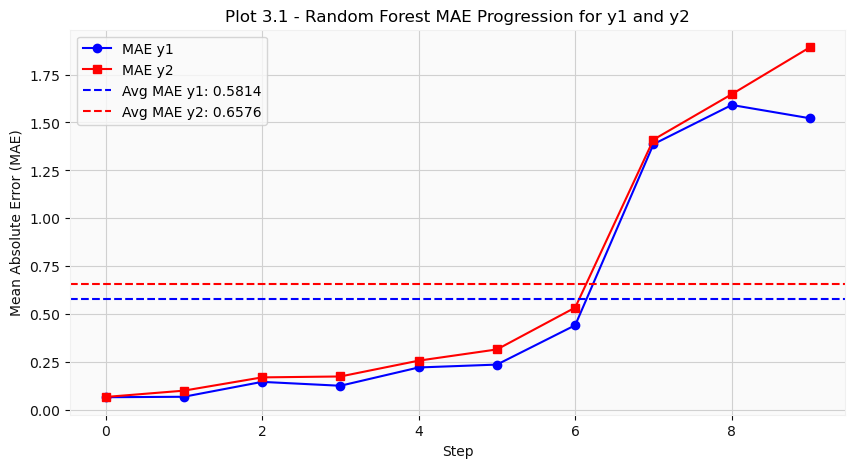

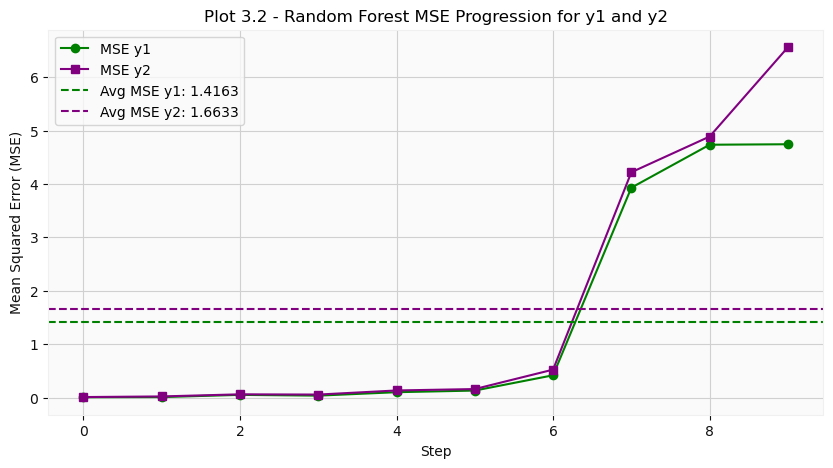

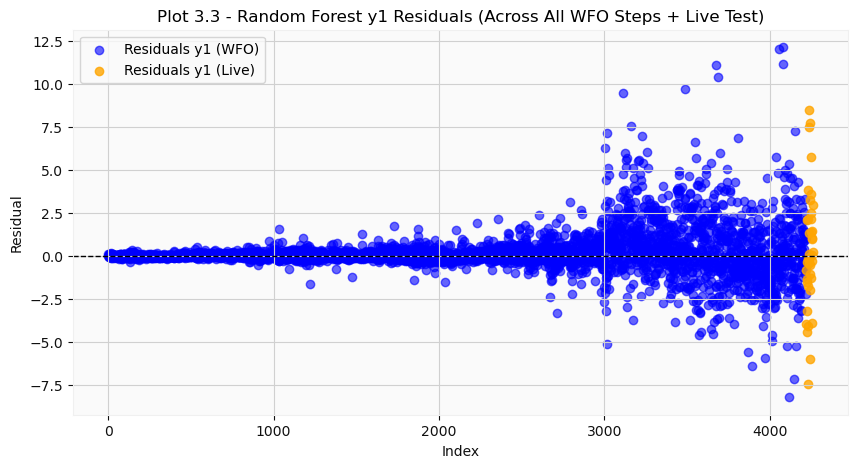

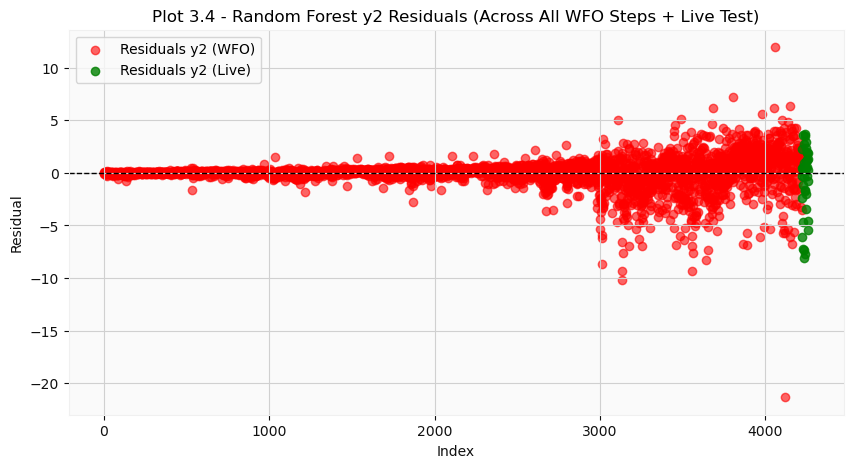

In [144]:
# Random Forest Visuals 

# Compute average MAE and MSE for y1 and y2
avg_mae_y1 = np.mean(mae_progress_y1)
avg_mae_y2 = np.mean(mae_progress_y2)
avg_mse_y1 = np.mean(mse_progress_y1)
avg_mse_y2 = np.mean(mse_progress_y2)

# Plot MAE for y1 and y2 with horizontal average lines
plt.figure(figsize=(10, 5))
plt.plot(mae_progress_y1, marker='o', linestyle='-', color='blue', label='MAE y1')
plt.plot(mae_progress_y2, marker='s', linestyle='-', color='red', label='MAE y2')
plt.axhline(avg_mae_y1, color='blue', linestyle='--', label=f'Avg MAE y1: {avg_mae_y1:.4f}')
plt.axhline(avg_mae_y2, color='red', linestyle='--', label=f'Avg MAE y2: {avg_mae_y2:.4f}')
plt.xlabel('Step')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Plot 3.1 - Random Forest MAE Progression for y1 and y2')
plt.legend()
plt.grid(True)
plt.show()

# Plot MSE for y1 and y2 with horizontal average lines
plt.figure(figsize=(10, 5))
plt.plot(mse_progress_y1, marker='o', linestyle='-', color='green', label='MSE y1')
plt.plot(mse_progress_y2, marker='s', linestyle='-', color='purple', label='MSE y2')
plt.axhline(avg_mse_y1, color='green', linestyle='--', label=f'Avg MSE y1: {avg_mse_y1:.4f}')
plt.axhline(avg_mse_y2, color='purple', linestyle='--', label=f'Avg MSE y2: {avg_mse_y2:.4f}')
plt.xlabel('Step')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Plot 3.2 - Random Forest MSE Progression for y1 and y2')
plt.legend()
plt.grid(True)
plt.show()

# Compute live residuals
X_live_y1 = X_live_y1.loc[y_live_y1.index].reset_index(drop=True)
X_live_y2 = X_live_y2.loc[y_live_y2.index].reset_index(drop=True)

predictions_live_y1 = rf_model_y1.predict(X_live_y1)
predictions_live_y2 = rf_model_y2.predict(X_live_y2)

residuals_live_y1 = y_live_y1.values - predictions_live_y1
residuals_live_y2 = y_live_y2.values - predictions_live_y2

# Plot residuals for y1 (including live residuals)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals_y1_all)), residuals_y1_all, color='blue', alpha=0.6, label='Residuals y1 (WFO)')
plt.scatter(range(len(residuals_y1_all), len(residuals_y1_all) + len(residuals_live_y1)), residuals_live_y1, 
            color='orange', alpha=0.8, label='Residuals y1 (Live)')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Plot 3.3 - Random Forest y1 Residuals (Across All WFO Steps + Live Test)')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals for y2 (including live residuals)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals_y2_all)), residuals_y2_all, color='red', alpha=0.6, label='Residuals y2 (WFO)')
plt.scatter(range(len(residuals_y2_all), len(residuals_y2_all) + len(residuals_live_y2)), residuals_live_y2, 
            color='green', alpha=0.8, label='Residuals y2 (Live)')
plt.axhline(0, color='black', linestyle='--', linewidth=1) 
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Plot 3.4 - Random Forest y2 Residuals (Across All WFO Steps + Live Test)')
plt.legend()
plt.grid(True)
plt.show()

eval_df['rf_avg_mae_y1'] = avg_mae_y1
eval_df['rf_avg_mae_y2'] = avg_mae_y2
eval_df['rf_avg_mse_y1'] = avg_mse_y1
eval_df['rf_avg_mse_y2'] = avg_mse_y2

eval_df['rf_residuals_y1_all'] = residuals_y1_all
eval_df['rf_residuals_y2_all'] = residuals_y2_all

# Calculate padding size
pad_size = len(eval_df) - len(residuals_live_y1)

# Pad with NaNs at the start
eval_df['rf_residuals_live_y1'] = np.pad(
    residuals_live_y1, 
    (pad_size, 0),  
    mode='constant', 
    constant_values=np.nan
)

eval_df['rf_residuals_live_y2'] = np.pad(
    residuals_live_y2, 
    (pad_size, 0),  
    mode='constant', 
    constant_values=np.nan
)


--- Random Forest Model Simulated Live Testing ---
NaNs in y_live_y1 after dropping: 0
NaNs in y_live_y2 after dropping: 0
NaNs in predictions_live_y1: 0
NaNs in predictions_live_y2: 0
Day 0: y1_forecast=4.0548, y2_forecast=0.2773
Day 0: y1_forecast=4.0548, y2_forecast=0.2773, Buy RR =14.6214, Sell RR =0.0684 
Triggered Buy Entry at day 0
Entry Price: 255.3092956542969, TP: 259.3641218072511, SL: 255.03197422907974, Buy RR: 14.621395190720252
SL hit at day 1 | Return: -0.11%
Day 1: y1_forecast=4.0225, y2_forecast=0.3097
Day 1: y1_forecast=4.0225, y2_forecast=0.3097, Buy RR =12.9900, Sell RR =0.0770 
Triggered Buy Entry at day 1
Entry Price: 251.9230194091797, TP: 255.94550570598196, SL: 251.61335812781064, Buy RR: 12.989955602516186
SL hit at day 2 | Return: -0.12%
Day 2: y1_forecast=4.0055, y2_forecast=0.3266
Day 2: y1_forecast=4.0055, y2_forecast=0.3266, Buy RR =12.2627, Sell RR =0.0815 
Triggered Buy Entry at day 2
Entry Price: 250.1449737548828, TP: 254.15047923366282, SL: 249.818

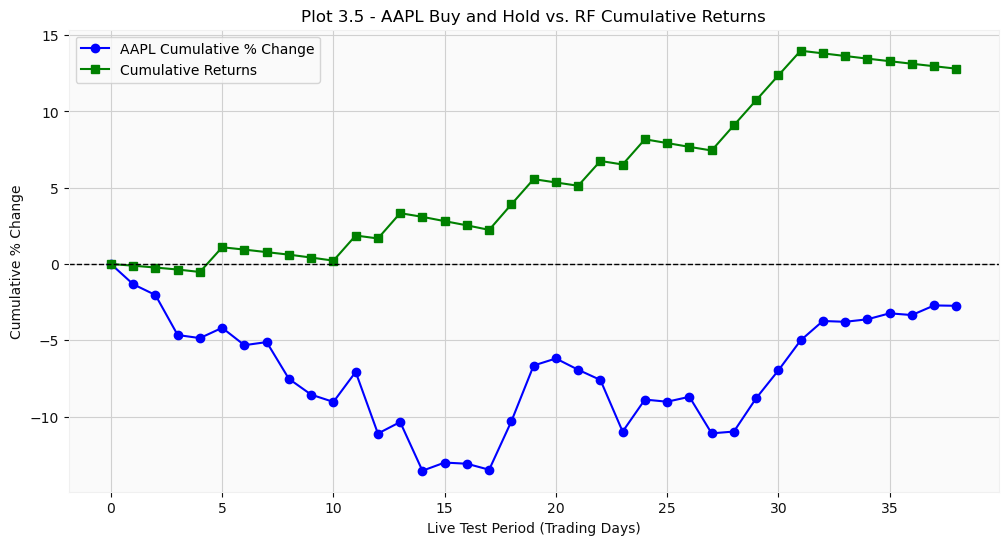

[-0.10862175 -0.23154076 -0.36212188 -0.52195227  1.0980693   0.94469776
  0.77855869  0.61468311  0.4231716   0.2196762   1.86843212  1.67385495
  3.33462708  3.0921813   2.81025722  2.53490941  2.23784431  3.9130373
  5.56604822  5.34570827  5.13076986  6.7556756   6.52408006  8.1771312
  7.9292247   7.67961059  7.44218208  9.09639847 10.7380413  12.36736464
 13.98367832 13.81073135 13.63718456 13.46548128 13.29817806 13.12959507
 12.96806023 12.80625414]


In [148]:
# RF Model Simulated Live Trading After Training
print("\n--- Random Forest Model Simulated Live Testing ---")

# Create a new DataFrame to store copies 
rf_live_test_df = pd.DataFrame()

# Copy live y-values
rf_live_test_df["y_live_y1"] = y_live_y1.copy()
rf_live_test_df["y_live_y2"] = y_live_y2.copy()

# Drop NaNs and reset indices
rf_live_test_df.dropna(subset=["y_live_y1", "y_live_y2"], inplace=True)
rf_live_test_df.reset_index(drop=True, inplace=True)

# Copy live X-values and drop corresponding rows
X_live_y1_copy = X_live_y1.loc[rf_live_test_df["y_live_y1"].index].copy()
X_live_y2_copy = X_live_y2.loc[rf_live_test_df["y_live_y2"].index].copy()

# Store X_live copies in the DataFrame
for col in X_live_y1_copy.columns:
    rf_live_test_df[f"X_live_y1_{col}"] = X_live_y1_copy[col].values

for col in X_live_y2_copy.columns:
    rf_live_test_df[f"X_live_y2_{col}"] = X_live_y2_copy[col].values

# Make predictions using copied data
rf_live_test_df["predictions_live_y1"] = rf_model_y1.predict(X_live_y1_copy) + X_live_y2_copy["AAPL_Close"].values
rf_live_test_df["predictions_live_y2"] = rf_model_y2.predict(X_live_y2_copy) + X_live_y2_copy["AAPL_Close"].values

# Adjust live y-values by adding AAPL_Close
rf_live_test_df["y_live_y1"] += X_live_y2_copy["AAPL_Close"].values
rf_live_test_df["y_live_y2"] += X_live_y2_copy["AAPL_Close"].values

# Evaluate performance on the live test set
print("NaNs in y_live_y1 after dropping:", rf_live_test_df["y_live_y1"].isna().sum())
print("NaNs in y_live_y2 after dropping:", rf_live_test_df["y_live_y2"].isna().sum())
print("NaNs in predictions_live_y1:", rf_live_test_df["predictions_live_y1"].isna().sum())
print("NaNs in predictions_live_y2:", rf_live_test_df["predictions_live_y2"].isna().sum())

# --- Fixed Risk-Reward Thresholds ---
buy_rr_value = 1.0  
sell_rr_value = 1.0  

# Ensure AAPL_High, AAPL_Low, and AAPL_Close are correctly transformed back
X_live_y1_copy['AAPL_High'] = scaler_high.inverse_transform(
    X_live_y1_copy[X_high.columns]  
)[:, X_high.columns.get_loc("AAPL_High")] 

X_live_y2_copy['AAPL_Low'] = scaler_low.inverse_transform(
    X_live_y2_copy[X_low.columns]
)[:, X_low.columns.get_loc("AAPL_Low")]  

X_live_y2_copy['AAPL_Close'] = scaler_low.inverse_transform(
    X_live_y2_copy[X_low.columns]
)[:, X_low.columns.get_loc("AAPL_Close")]  

# Initialize tracking variables
returns = []
entry_price = None
take_profit = None
stop_loss = None

# Simulated Trading Logic
for i in range(len(rf_live_test_df["y_live_y1"]) - 2):
    
    # Store absolute values of predictions
    pred_high_i = abs(rf_live_test_df['predictions_live_y1'].iloc[i])
    pred_low_i = abs(rf_live_test_df['predictions_live_y2'].iloc[i])
    
    print(f"Day {i}: y1_forecast={pred_high_i:.4f}, y2_forecast={pred_low_i:.4f}")

    # Compute risk-reward ratios using stored absolute values
    buy_rr_current = pred_high_i / pred_low_i
    sell_rr_current = pred_low_i / pred_high_i

    print(f"Day {i}: y1_forecast={pred_high_i:.4f}, y2_forecast={pred_low_i:.4f}, Buy RR ={buy_rr_current:.4f}, Sell RR ={sell_rr_current:.4f} ")

    # Buy Entry Condition
    if buy_rr_current > buy_rr_value and entry_price is None:
        print(f"Triggered Buy Entry at day {i}")
        entry_price = X_live_y2_copy.iloc[i]["AAPL_Close"]  
        take_profit = X_live_y2_copy.iloc[i]["AAPL_Close"]  + pred_high_i
        stop_loss = X_live_y2_copy.iloc[i]["AAPL_Close"]  - pred_low_i
        print(f"Entry Price: {entry_price}, TP: {take_profit}, SL: {stop_loss}, Buy RR: {buy_rr_current}")

    # Sell Entry Condition
    if sell_rr_current > sell_rr_value and entry_price is None:
        print(f"Triggered Sell Entry at day {i}")
        entry_price = X_live_y2_copy.iloc[i]["AAPL_Close"]  
        take_profit = X_live_y2_copy.iloc[i]["AAPL_Close"] - pred_low_i
        stop_loss = X_live_y2_copy.iloc[i]["AAPL_Close"]  + pred_high_i
        print(f"Entry Price: {entry_price}, TP: {take_profit}, SL: {stop_loss}, Sell RR: {sell_rr_current}")

    # Buy Exit
    if entry_price is not None and (take_profit > stop_loss):
        high = X_live_y1_copy.iloc[i + 1]["AAPL_High"]
        low = X_live_y2_copy.iloc[i + 1]["AAPL_Low"]
    
        # Take Profit Hit
        if high >= take_profit:  
            return_value = (((take_profit - entry_price) / entry_price) * 100) 
            print(f"TP hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None
    
        # Stop Loss Hit
        elif low <= stop_loss:  
            return_value = (((entry_price - stop_loss) / entry_price) * -100) 
            print(f"SL hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None

        if i == len(rf_live_test_df["y_live_y1"]) - 3 and entry_price is not None:
            exit_price = X_live_y2_copy.iloc[i + 1]["AAPL_Close"]  
            return_value = (((exit_price - entry_price) / entry_price) * 100)  
            print(f"Close Open Position at day {i + 1} | Exit Price: {exit_price} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None

    # Sell Exit
    if entry_price is not None and (take_profit < stop_loss):
        high = X_live_y1_copy.iloc[i + 1]["AAPL_High"]
        low = X_live_y2_copy.iloc[i + 1]["AAPL_Low"]
    
        # Take Profit Hit
        if low <= take_profit:  
            return_value = (((entry_price - take_profit) / entry_price) * 100) 
            print(f"TP hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None
    
        # Stop Loss Hit
        elif high >= stop_loss:  
            return_value = (((stop_loss - entry_price) / entry_price) * -100) 
            print(f"SL hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None

        # Force Exit on Last Iteration if Trade is Still Open
        if i == len(rf_live_test_df["y_live_y1"]) - 3 and entry_price is not None:
            exit_price = X_live_y2_copy.iloc[i + 1]["AAPL_Close"]  
            return_value = (((entry_price - exit_price) / entry_price) * 100)  
            print(f"Close Open Position at day {i + 1} | Exit Price: {exit_price} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None  # Ensure cleanup
  
# Compute cumulative percentage change for AAPL_Close
aapl_cumulative_pct_change = X_live_y2_copy["AAPL_Close"].pct_change().fillna(0).cumsum() * 100  
aapl_cumulative_pct_change = aapl_cumulative_pct_change.iloc[:-2]

# Convert returns list to cumulative sum array
cumulative_returns = np.cumsum(returns) 

# Create correct trading day index
trading_days = list(range(len(rf_live_test_df["y_live_y1"]) - 2))

# Returns Period
full_cumulative_returns = np.zeros(len(trading_days))  
start_index = len(trading_days) - len(cumulative_returns)  
full_cumulative_returns[start_index:] = cumulative_returns  

# Plot AAPL cumulative % change
plt.figure(figsize=(12, 6))
plt.plot(aapl_cumulative_pct_change.index, aapl_cumulative_pct_change, linestyle='-', marker='o', color='blue', label='AAPL Cumulative % Change')

# Plot corrected cumulative returns
plt.plot(trading_days, full_cumulative_returns, linestyle='-', marker='s', color='green', label='Cumulative Returns')

# Add labels and title
plt.xlabel('Live Test Period (Trading Days)')
plt.ylabel('Cumulative % Change')
plt.title('Plot 3.5 - AAPL Buy and Hold vs. RF Cumulative Returns')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
print(cumulative_returns)

# Ensure all arrays are of float type before padding
full_cumulative_returns = full_cumulative_returns.astype(float)
trading_days = np.array(trading_days, dtype=float)
aapl_cumulative_pct_change = aapl_cumulative_pct_change.astype(float)

# Calculate padding sizes individually for each column
pad_size_rf_returns = len(eval_df) - len(full_cumulative_returns)
pad_size_trading_days = len(eval_df) - len(trading_days)
pad_size_aapl_pct_change = len(eval_df) - len(aapl_cumulative_pct_change)

# Pad rf_cumulative_returns
eval_df['rf_cumulative_returns'] = np.pad(
    full_cumulative_returns, 
    (pad_size_rf_returns, 0),  
    mode='constant', 
    constant_values=np.nan
)

# Pad trading_days
eval_df['trading_days'] = np.pad(
    trading_days, 
    (pad_size_trading_days, 0),  
    mode='constant', 
    constant_values=np.nan
)

# Pad aapl_cumulative_pct_change
eval_df['aapl_cumulative_pct_change'] = np.pad(
    aapl_cumulative_pct_change, 
    (pad_size_aapl_pct_change, 0),  
    mode='constant', 
    constant_values=np.nan
)

In [150]:
# XGBoost Optimized Model
xgboost_df = feature_df.copy()

y1 = xgboost_df['target_long_returns']
y2 = xgboost_df['target_short_returns']

# Reserve the last 1% of rows for simulated live testing 
live_test_size = int(0.01 * len(xgboost_df))  

# Split the dataset into training + validation, and live test set
X_live_y1 = X_high_transformed.iloc[-live_test_size:].reset_index(drop=True)
X_live_y2 = X_low_transformed.iloc[-live_test_size:].reset_index(drop=True)

y_live_y1 = y1.iloc[-live_test_size:].reset_index(drop=True)
y_live_y2 = y2.iloc[-live_test_size:].reset_index(drop=True)

# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

y1_train_data = y1.iloc[:-live_test_size].reset_index(drop=True)
y2_train_data = y2.iloc[:-live_test_size].reset_index(drop=True)

# Initialize models and metric trackers
mae_progress_y1, mse_progress_y1 = [], []
mae_progress_y2, mse_progress_y2 = [], []
predictions_y1_all, predictions_y2_all = [], []

params_y1 = {
    'objective': 'reg:squarederror', 
    'learning_rate': 0.01,  
    'max_depth': 5,  
    'n_estimators': 300, 
    'subsample': 0.9,  
    'colsample_bytree': 0.7,  
    'reg_alpha': 1.0,  
    'reg_lambda': 0.1 
}

params_y2 = {
    'objective': 'reg:squarederror', 
    'learning_rate': 0.01,  
    'max_depth': 7,  
    'n_estimators': 100, 
    'subsample': 0.7,  
    'colsample_bytree': 0.9,  
    'reg_alpha': 1.0,  
    'reg_lambda': 1.0 
}

n_splits = 10
test_size = int(len(X_train_data_y1) / n_splits)  

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Prepare the dataset excluding y_live for y1 and y2
# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

# Initialize lists to store residuals for all WFO steps
residuals_y1_all = []
residuals_y2_all = []

for train_index, test_index in tscv.split(X_train_data_y1):
    train_index = np.arange(0, test_index[0])

    X_train_y1, X_test_y1 = X_train_data_y1.iloc[train_index], X_train_data_y1.iloc[test_index]
    y_train_y1, y_test_y1 = y1_train_data.iloc[train_index], y1_train_data.iloc[test_index]

    X_train_y2, X_test_y2 = X_train_data_y2.iloc[train_index], X_train_data_y2.iloc[test_index]
    y_train_y2, y_test_y2 = y2_train_data.iloc[train_index], y2_train_data.iloc[test_index]

    xgb_model_y1 = XGBRegressor(**params_y1)
    xgb_model_y2 = XGBRegressor(**params_y2)

    xgb_model_y1.fit(
    X_train_y1, y_train_y1,
    eval_set=[(X_test_y1, y_test_y1)],
    verbose=False
    )

    xgb_model_y2.fit(
    X_train_y2, y_train_y2,
    eval_set=[(X_test_y2, y_test_y2)],
    verbose=False
    )

    # Predictions
    predictions_y1 = xgb_model_y1.predict(X_test_y1)
    predictions_y2 = xgb_model_y2.predict(X_test_y2)
    
    # Store predictions
    predictions_y1_all.extend(predictions_y1)
    predictions_y2_all.extend(predictions_y2)

    # Compute residuals and store them
    residuals_y1_all.extend(y_test_y1.values - predictions_y1)
    residuals_y2_all.extend(y_test_y2.values - predictions_y2)

    # Calculate metrics for y1
    mae_y1 = mean_absolute_error(y_test_y1, predictions_y1)
    mse_y1 = mean_squared_error(y_test_y1, predictions_y1)
    mae_progress_y1.append(mae_y1)
    mse_progress_y1.append(mse_y1)

    # Calculate metrics for y2
    mae_y2 = mean_absolute_error(y_test_y2, predictions_y2)
    mse_y2 = mean_squared_error(y_test_y2, predictions_y2)
    mae_progress_y2.append(mae_y2)
    mse_progress_y2.append(mse_y2)

    print(f"MAE y1: {mae_y1:.4f}, MSE y1: {mse_y1:.4f} | MAE y2: {mae_y2:.4f}, MSE y2: {mse_y2:.4f}")

# Convert lists to numpy arrays
residuals_y1_all = np.array(residuals_y1_all)
residuals_y2_all = np.array(residuals_y2_all)

MAE y1: 0.0669, MSE y1: 0.0070 | MAE y2: 0.0686, MSE y2: 0.0101
MAE y1: 0.0700, MSE y1: 0.0098 | MAE y2: 0.0898, MSE y2: 0.0204
MAE y1: 0.1598, MSE y1: 0.0586 | MAE y2: 0.1752, MSE y2: 0.0647
MAE y1: 0.1647, MSE y1: 0.0541 | MAE y2: 0.1554, MSE y2: 0.0520
MAE y1: 0.2191, MSE y1: 0.1024 | MAE y2: 0.2493, MSE y2: 0.1336
MAE y1: 0.2540, MSE y1: 0.1533 | MAE y2: 0.2520, MSE y2: 0.1390
MAE y1: 0.4973, MSE y1: 0.4993 | MAE y2: 0.4865, MSE y2: 0.5254
MAE y1: 1.3524, MSE y1: 3.7621 | MAE y2: 1.4631, MSE y2: 4.4911
MAE y1: 1.5983, MSE y1: 4.8173 | MAE y2: 1.6757, MSE y2: 5.2459
MAE y1: 1.5705, MSE y1: 5.2834 | MAE y2: 1.6706, MSE y2: 5.9002


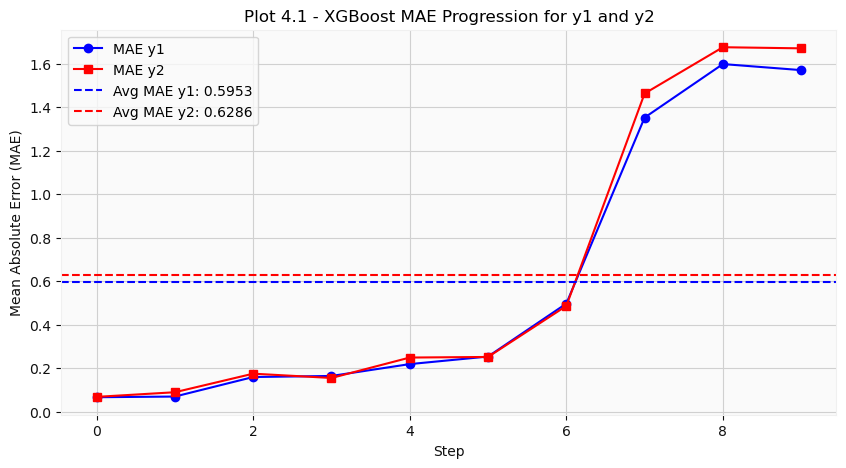

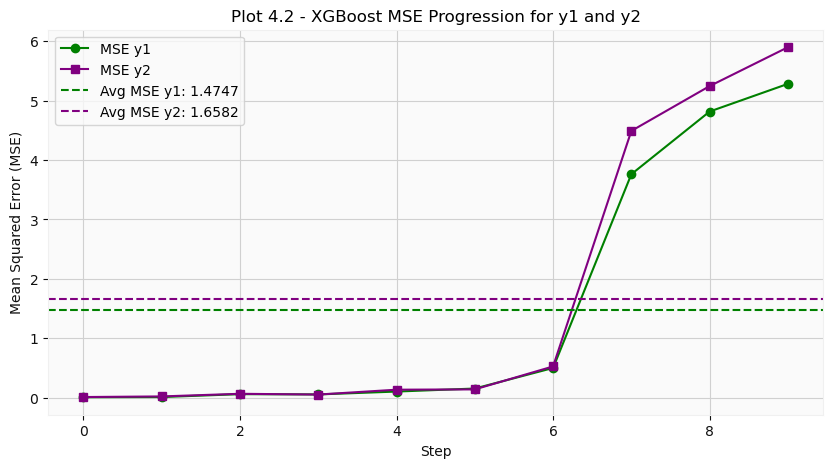

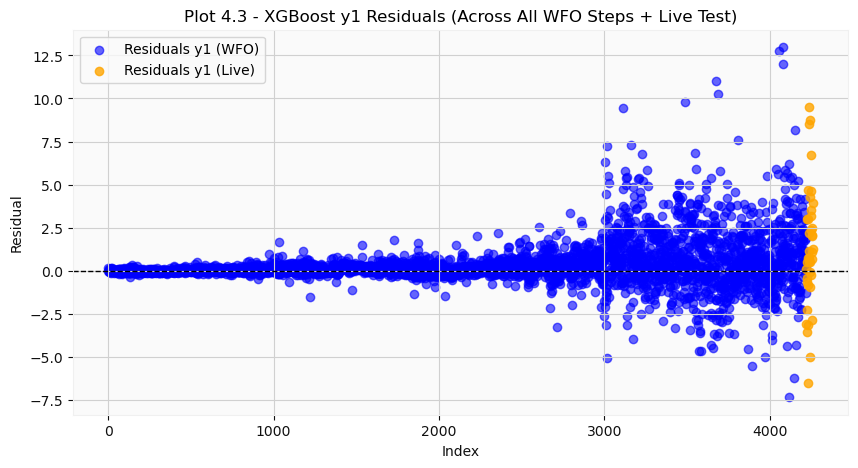

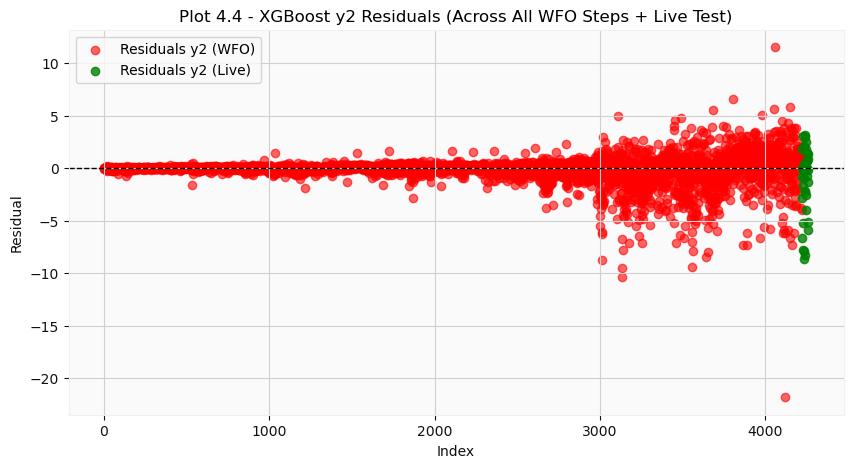

In [154]:
# XGBoost Visuals

# Compute average MAE and MSE for y1 and y2
avg_mae_y1 = np.mean(mae_progress_y1)
avg_mae_y2 = np.mean(mae_progress_y2)
avg_mse_y1 = np.mean(mse_progress_y1)
avg_mse_y2 = np.mean(mse_progress_y2)

# Plot MAE for y1 and y2 with horizontal average lines
plt.figure(figsize=(10, 5))
plt.plot(mae_progress_y1, marker='o', linestyle='-', color='blue', label='MAE y1')
plt.plot(mae_progress_y2, marker='s', linestyle='-', color='red', label='MAE y2')
plt.axhline(avg_mae_y1, color='blue', linestyle='--', label=f'Avg MAE y1: {avg_mae_y1:.4f}')
plt.axhline(avg_mae_y2, color='red', linestyle='--', label=f'Avg MAE y2: {avg_mae_y2:.4f}')
plt.xlabel('Step')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Plot 4.1 - XGBoost MAE Progression for y1 and y2')
plt.legend()
plt.grid(True)
plt.show()

# Plot MSE for y1 and y2 with horizontal average lines
plt.figure(figsize=(10, 5))
plt.plot(mse_progress_y1, marker='o', linestyle='-', color='green', label='MSE y1')
plt.plot(mse_progress_y2, marker='s', linestyle='-', color='purple', label='MSE y2')
plt.axhline(avg_mse_y1, color='green', linestyle='--', label=f'Avg MSE y1: {avg_mse_y1:.4f}')
plt.axhline(avg_mse_y2, color='purple', linestyle='--', label=f'Avg MSE y2: {avg_mse_y2:.4f}')
plt.xlabel('Step')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Plot 4.2 - XGBoost MSE Progression for y1 and y2')
plt.legend()
plt.grid(True)
plt.show()

# Compute live residuals
X_live_y1 = X_live_y1.loc[y_live_y1.index].reset_index(drop=True)
X_live_y2 = X_live_y2.loc[y_live_y2.index].reset_index(drop=True)

predictions_live_y1 = xgb_model_y1.predict(X_live_y1)
predictions_live_y2 = xgb_model_y2.predict(X_live_y2)

residuals_live_y1 = y_live_y1.values - predictions_live_y1
residuals_live_y2 = y_live_y2.values - predictions_live_y2

# Plot residuals for y1 (including live residuals)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals_y1_all)), residuals_y1_all, color='blue', alpha=0.6, label='Residuals y1 (WFO)')
plt.scatter(range(len(residuals_y1_all), len(residuals_y1_all) + len(residuals_live_y1)), residuals_live_y1, 
            color='orange', alpha=0.8, label='Residuals y1 (Live)')
plt.axhline(0, color='black', linestyle='--', linewidth=1) 
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Plot 4.3 - XGBoost y1 Residuals (Across All WFO Steps + Live Test)')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals for y2 (including live residuals)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals_y2_all)), residuals_y2_all, color='red', alpha=0.6, label='Residuals y2 (WFO)')
plt.scatter(range(len(residuals_y2_all), len(residuals_y2_all) + len(residuals_live_y2)), residuals_live_y2, 
            color='green', alpha=0.8, label='Residuals y2 (Live)')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Plot 4.4 - XGBoost y2 Residuals (Across All WFO Steps + Live Test)')
plt.legend()
plt.grid(True)
plt.show()

eval_df['xgb_avg_mae_y1'] = avg_mae_y1
eval_df['xgb_avg_mae_y2'] = avg_mae_y2
eval_df['xgb_avg_mse_y1'] = avg_mse_y1
eval_df['xgb_avg_mse_y2'] = avg_mse_y2

eval_df['xgb_residuals_y1_all'] = residuals_y1_all
eval_df['xgb_residuals_y2_all'] = residuals_y2_all

# Calculate padding size
pad_size = len(eval_df) - len(residuals_live_y1)

# Pad with NaNs at the start
eval_df['xgb_residuals_live_y1'] = np.pad(
    residuals_live_y1, 
    (pad_size, 0), 
    mode='constant', 
    constant_values=np.nan
)

eval_df['xgb_residuals_live_y2'] = np.pad(
    residuals_live_y2, 
    (pad_size, 0), 
    mode='constant', 
    constant_values=np.nan
)


--- XGB Model Simulated Live Testing ---
NaNs in y_live_y1 after dropping: 0
NaNs in y_live_y2 after dropping: 0
NaNs in predictions_live_y1: 0
NaNs in predictions_live_y2: 0
Day 0: y1_forecast=3.1656, y2_forecast=0.2161
Day 0: y1_forecast=3.1656, y2_forecast=0.2161, Buy RR =14.6513, Sell RR =0.0683 
Triggered Buy Entry at day 0
Entry Price: 255.3092956542969, TP: 258.47488780864734, SL: 255.09323350540149, Buy RR: 14.651303666718674
SL hit at day 1 | Return: -0.08%
Day 1: y1_forecast=3.1333, y2_forecast=0.1837
Day 1: y1_forecast=3.1333, y2_forecast=0.1837, Buy RR =17.0543, Sell RR =0.0586 
Triggered Buy Entry at day 1
Entry Price: 251.9230194091797, TP: 255.05627170737824, SL: 251.73929711643615, Buy RR: 17.054284765389777
SL hit at day 2 | Return: -0.07%
Day 2: y1_forecast=3.1163, y2_forecast=0.1667
Day 2: y1_forecast=3.1163, y2_forecast=0.1667, Buy RR =18.6892, Sell RR =0.0535 
Triggered Buy Entry at day 2
Entry Price: 250.1449737548828, TP: 253.2612452350591, SL: 249.9782322801615

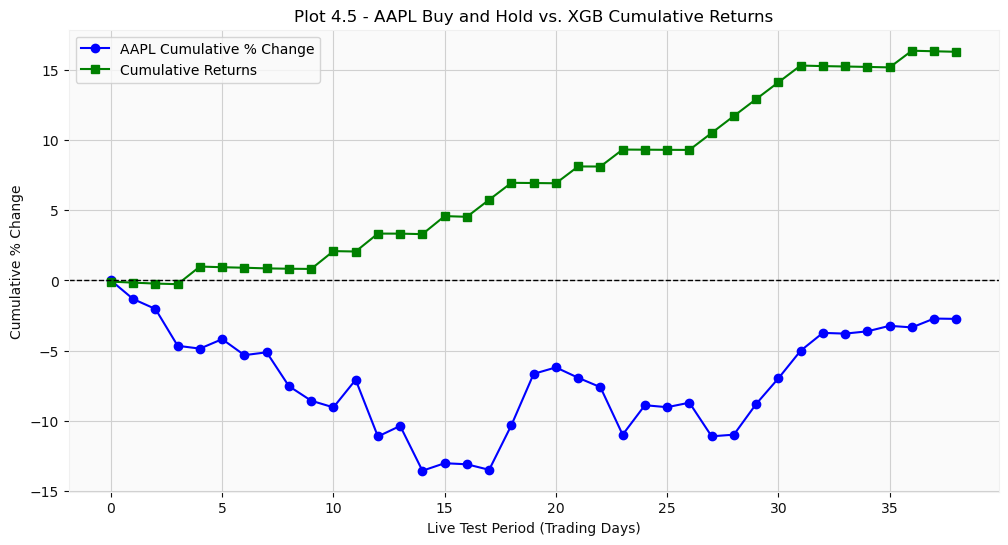

In [158]:
# XGB Model Simulated Live Trading After Training
print("\n--- XGB Model Simulated Live Testing ---")

# Create a new DataFrame to store copies 
xgb_live_test_df = pd.DataFrame()

# Copy live y-values
xgb_live_test_df["y_live_y1"] = y_live_y1.copy()
xgb_live_test_df["y_live_y2"] = y_live_y2.copy()

# Drop NaNs and reset indices
xgb_live_test_df.dropna(subset=["y_live_y1", "y_live_y2"], inplace=True)
xgb_live_test_df.reset_index(drop=True, inplace=True)

# Copy live X-values and drop corresponding rows
X_live_y1_copy = X_live_y1.loc[xgb_live_test_df["y_live_y1"].index].copy()
X_live_y2_copy = X_live_y2.loc[xgb_live_test_df["y_live_y2"].index].copy()

# Store X_live copies in the DataFrame
for col in X_live_y1_copy.columns:
    xgb_live_test_df[f"X_live_y1_{col}"] = X_live_y1_copy[col].values

for col in X_live_y2_copy.columns:
    xgb_live_test_df[f"X_live_y2_{col}"] = X_live_y2_copy[col].values

# Make predictions using copied data
xgb_live_test_df["predictions_live_y1"] = xgb_model_y1.predict(X_live_y1_copy) + X_live_y2_copy["AAPL_Close"].values
xgb_live_test_df["predictions_live_y2"] = xgb_model_y2.predict(X_live_y2_copy) + X_live_y2_copy["AAPL_Close"].values

# Adjust live y-values by adding AAPL_Close
xgb_live_test_df["y_live_y1"] += X_live_y2_copy["AAPL_Close"].values
xgb_live_test_df["y_live_y2"] += X_live_y2_copy["AAPL_Close"].values

# Evaluate performance on the live test set
print("NaNs in y_live_y1 after dropping:", xgb_live_test_df["y_live_y1"].isna().sum())
print("NaNs in y_live_y2 after dropping:", xgb_live_test_df["y_live_y2"].isna().sum())
print("NaNs in predictions_live_y1:", xgb_live_test_df["predictions_live_y1"].isna().sum())
print("NaNs in predictions_live_y2:", xgb_live_test_df["predictions_live_y2"].isna().sum())

# --- Fixed Risk-Reward Thresholds ---
buy_rr_value = 1.0  
sell_rr_value = 1.0  

# Ensure AAPL_High, AAPL_Low, and AAPL_Close are correctly transformed back
X_live_y1_copy['AAPL_High'] = scaler_high.inverse_transform(
    X_live_y1_copy[X_high.columns]  
)[:, X_high.columns.get_loc("AAPL_High")] 

X_live_y2_copy['AAPL_Low'] = scaler_low.inverse_transform(
    X_live_y2_copy[X_low.columns]
)[:, X_low.columns.get_loc("AAPL_Low")]  

X_live_y2_copy['AAPL_Close'] = scaler_low.inverse_transform(
    X_live_y2_copy[X_low.columns]
)[:, X_low.columns.get_loc("AAPL_Close")]  

# Initialize tracking variables
returns = []
entry_price = None
take_profit = None
stop_loss = None

# Simulated Trading Logic
for i in range(len(xgb_live_test_df["y_live_y1"]) - 2):
    # Store absolute values of predictions
    pred_high_i = abs(xgb_live_test_df['predictions_live_y1'].iloc[i])
    pred_low_i = abs(xgb_live_test_df['predictions_live_y2'].iloc[i])
    
    print(f"Day {i}: y1_forecast={pred_high_i:.4f}, y2_forecast={pred_low_i:.4f}")

    # Compute risk-reward ratios using stored absolute values
    buy_rr_current = pred_high_i / pred_low_i
    sell_rr_current = pred_low_i / pred_high_i

    print(f"Day {i}: y1_forecast={pred_high_i:.4f}, y2_forecast={pred_low_i:.4f}, Buy RR ={buy_rr_current:.4f}, Sell RR ={sell_rr_current:.4f} ")

    # Buy Entry Condition
    if buy_rr_current > buy_rr_value and entry_price is None:
        print(f"Triggered Buy Entry at day {i}")
        entry_price = X_live_y2_copy.iloc[i]["AAPL_Close"]  
        take_profit = X_live_y2_copy.iloc[i]["AAPL_Close"]  + pred_high_i
        stop_loss = X_live_y2_copy.iloc[i]["AAPL_Close"]  - pred_low_i
        print(f"Entry Price: {entry_price}, TP: {take_profit}, SL: {stop_loss}, Buy RR: {buy_rr_current}")

    # Sell Entry Condition
    if sell_rr_current > sell_rr_value and entry_price is None:
        print(f"Triggered Sell Entry at day {i}")
        entry_price = X_live_y2_copy.iloc[i]["AAPL_Close"]  
        take_profit = X_live_y2_copy.iloc[i]["AAPL_Close"] - pred_low_i
        stop_loss = X_live_y2_copy.iloc[i]["AAPL_Close"]  + pred_high_i
        print(f"Entry Price: {entry_price}, TP: {take_profit}, SL: {stop_loss}, Sell RR: {sell_rr_current}")

    # Buy Exit
    if entry_price is not None and (take_profit > stop_loss):
        high = X_live_y1_copy.iloc[i + 1]["AAPL_High"]
        low = X_live_y2_copy.iloc[i + 1]["AAPL_Low"]
    
        # Take Profit Hit
        if high >= take_profit:  
            return_value = (((take_profit - entry_price) / entry_price) * 100) 
            print(f"TP hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None
    
        # Stop Loss Hit
        elif low <= stop_loss:  
            return_value = (((entry_price - stop_loss) / entry_price) * -100) 
            print(f"SL hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None

        if i == len(xgb_live_test_df["y_live_y1"]) - 3 and entry_price is not None:
            exit_price = X_live_y2_copy.iloc[i + 1]["AAPL_Close"]  
            return_value = (((exit_price - entry_price) / entry_price) * 100)  
            print(f"Close Open Position at day {i + 1} | Exit Price: {exit_price} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None

    # Sell Exit
    if entry_price is not None and (take_profit < stop_loss):
        high = X_live_y1_copy.iloc[i + 1]["AAPL_High"]
        low = X_live_y2_copy.iloc[i + 1]["AAPL_Low"]
    
        # Take Profit Hit
        if low <= take_profit:  
            return_value = (((entry_price - take_profit) / entry_price) * 100) 
            print(f"TP hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None
    
        # Stop Loss Hit
        elif high >= stop_loss:  
            return_value = (((stop_loss - entry_price) / entry_price) * -100) 
            print(f"SL hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None

        # Force Exit on Last Iteration if Trade is Still Open
        if i == len(xgb_live_test_df["y_live_y1"]) - 3 and entry_price is not None:
            exit_price = X_live_y2_copy.iloc[i + 1]["AAPL_Close"] 
            return_value = (((entry_price - exit_price) / entry_price) * 100)  
            print(f"Close Open Position at day {i + 1} | Exit Price: {exit_price} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None  
   
# Compute cumulative percentage change for AAPL_Close
aapl_cumulative_pct_change = X_live_y2_copy["AAPL_Close"].pct_change().fillna(0).cumsum() * 100  # Convert to %
aapl_cumulative_pct_change = aapl_cumulative_pct_change.iloc[:-2]

# Convert returns list to cumulative sum array
cumulative_returns = np.cumsum(returns)  

# Create correct trading day index
trading_days = list(range(len(xgb_live_test_df["y_live_y1"]) - 2))

# Cumulative Returns Period
full_cumulative_returns = np.zeros(len(trading_days))  
start_index = len(trading_days) - len(cumulative_returns) 
full_cumulative_returns[start_index:] = cumulative_returns 

# Plot AAPL cumulative % change
plt.figure(figsize=(12, 6))
plt.plot(aapl_cumulative_pct_change.index, aapl_cumulative_pct_change, linestyle='-', marker='o', color='blue', label='AAPL Cumulative % Change')

# Plot corrected cumulative returns (aligned properly)
plt.plot(trading_days, full_cumulative_returns, linestyle='-', marker='s', color='green', label='Cumulative Returns')

# Add labels and title
plt.xlabel('Live Test Period (Trading Days)')
plt.ylabel('Cumulative % Change')
plt.title('Plot 4.5 - AAPL Buy and Hold vs. XGB Cumulative Returns')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
cumulative_returns

# Ensure all arrays are of float type before padding
full_cumulative_returns = full_cumulative_returns.astype(float)

# Calculate padding sizes individually for each column
pad_size_xgb_returns = len(eval_df) - len(full_cumulative_returns)

# Pad xgb_cumulative_returns
eval_df['xgb_cumulative_returns'] = np.pad(
    full_cumulative_returns, 
    (pad_size_xgb_returns, 0),  
    mode='constant', 
    constant_values=np.nan
)

In [162]:
# LGBM Optimized Model
lgbm_df = feature_df.copy()

y1 = lgbm_df['target_long_returns']
y2 = lgbm_df['target_short_returns']

# Reserve the last 1% of rows for simulated live testing 
live_test_size = int(0.01 * len(lgbm_df))  

# Split the dataset into training + validation, and live test set
X_live_y1 = X_high_transformed.iloc[-live_test_size:].reset_index(drop=True)
X_live_y2 = X_low_transformed.iloc[-live_test_size:].reset_index(drop=True)

y_live_y1 = y1.iloc[-live_test_size:].reset_index(drop=True)
y_live_y2 = y2.iloc[-live_test_size:].reset_index(drop=True)

# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

y1_train_data = y1.iloc[:-live_test_size].reset_index(drop=True)
y2_train_data = y2.iloc[:-live_test_size].reset_index(drop=True)

# Initialize models and metric trackers
mae_progress_y1, mse_progress_y1 = [], []
mae_progress_y2, mse_progress_y2 = [], []
predictions_y1_all, predictions_y2_all = [], []

params_y1 = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,  
    'num_leaves': 64,  
    'max_depth': 4,  
    'min_data_in_leaf': 30,  
    'bagging_freq': 4,
    'lambda_l1': 0.1,  
    'lambda_l2': 0.1,  
    'bagging_fraction': 0.9,  
    'feature_fraction': 0.9,  
}

params_y2 = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,  
    'num_leaves': 16,  
    'max_depth': 4,  
    'min_data_in_leaf': 30,  
    'bagging_freq': 4,
    'lambda_l1': 1.0,  
    'lambda_l2': 0.0,  
    'bagging_fraction': 0.9,  
    'feature_fraction': 0.7,  
}

n_splits = 10
test_size = int(len(X_train_data_y1) / n_splits)  

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

# Prepare the dataset excluding y_live for y1 and y2
# Training set excluding live test data
X_train_data_y1 = X_high_transformed.iloc[:-live_test_size].reset_index(drop=True)
X_train_data_y2 = X_low_transformed.iloc[:-live_test_size].reset_index(drop=True)

# Initialize lists to store residuals for all WFO steps
residuals_y1_all = []
residuals_y2_all = []

for train_index, test_index in tscv.split(X_train_data_y1):
    train_index = np.arange(0, test_index[0])

    X_train_y1, X_test_y1 = X_train_data_y1.iloc[train_index], X_train_data_y1.iloc[test_index]
    y_train_y1, y_test_y1 = y1_train_data.iloc[train_index], y1_train_data.iloc[test_index]

    X_train_y2, X_test_y2 = X_train_data_y2.iloc[train_index], X_train_data_y2.iloc[test_index]
    y_train_y2, y_test_y2 = y2_train_data.iloc[train_index], y2_train_data.iloc[test_index]

    lgbm_train_data_y1 = lgb.Dataset(X_train_y1, label=y_train_y1)
    lgbm_val_data_y1 = lgb.Dataset(X_test_y1, label=y_test_y1)

    lgbm_train_data_y2 = lgb.Dataset(X_train_y2, label=y_train_y2)
    lgbm_val_data_y2 = lgb.Dataset(X_test_y2, label=y_test_y2)

    lgbm_model_y1 = lgb.train(
        params_y1,
        lgbm_train_data_y1,
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
        valid_sets=[lgbm_train_data_y1, lgbm_val_data_y1],
        valid_names=['train_y1', 'valid_y1']
    )

    lgbm_model_y2 = lgb.train(
        params_y2,
        lgbm_train_data_y2,
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
        valid_sets=[lgbm_train_data_y2, lgbm_val_data_y2],
        valid_names=['train_y2', 'valid_y2']
    )

    # Predictions
    predictions_y1 = lgbm_model_y1.predict(X_test_y1)
    predictions_y2 = lgbm_model_y2.predict(X_test_y2)

    # Store predictions
    predictions_y1_all.extend(predictions_y1)
    predictions_y2_all.extend(predictions_y2)

    # Compute residuals and store them
    residuals_y1_all.extend(y_test_y1.values - predictions_y1)
    residuals_y2_all.extend(y_test_y2.values - predictions_y2)

    # Calculate metrics for y1
    mae_y1 = mean_absolute_error(y_test_y1, predictions_y1)
    mse_y1 = mean_squared_error(y_test_y1, predictions_y1)
    mae_progress_y1.append(mae_y1)
    mse_progress_y1.append(mse_y1)

    # Calculate metrics for y2
    mae_y2 = mean_absolute_error(y_test_y2, predictions_y2)
    mse_y2 = mean_squared_error(y_test_y2, predictions_y2)
    mae_progress_y2.append(mae_y2)
    mse_progress_y2.append(mse_y2)

    print(f"MAE y1: {mae_y1:.4f}, MSE y1: {mse_y1:.4f} | MAE y2: {mae_y2:.4f}, MSE y2: {mse_y2:.4f}")

# Convert lists to numpy arrays
residuals_y1_all = np.array(residuals_y1_all)
residuals_y2_all = np.array(residuals_y2_all)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train_y1's l2: 0.00317178	valid_y1's l2: 0.0070098
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train_y2's l2: 0.00500693	valid_y2's l2: 0.0100769
MAE y1: 0.0669, MSE y1: 0.0070 | MAE y2: 0.0686, MSE y2: 0.0101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train_y1's l2: 0.00623042	valid_y1's l2: 0.00966146
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train_y2's l2: 0.00917407	valid_y2's l2: 0.0201944
MAE y1: 0.0697, MSE y1: 0.0097 | MAE y2: 0.0883, MSE y2: 0.0202
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[812]	train_y1's l2: 0.00564834	valid_y1's l2: 0.0520974
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[528]	train_y2's l

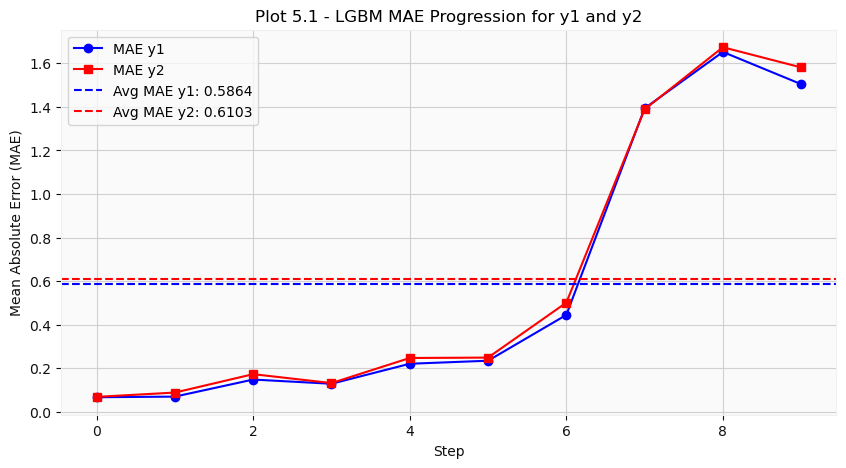

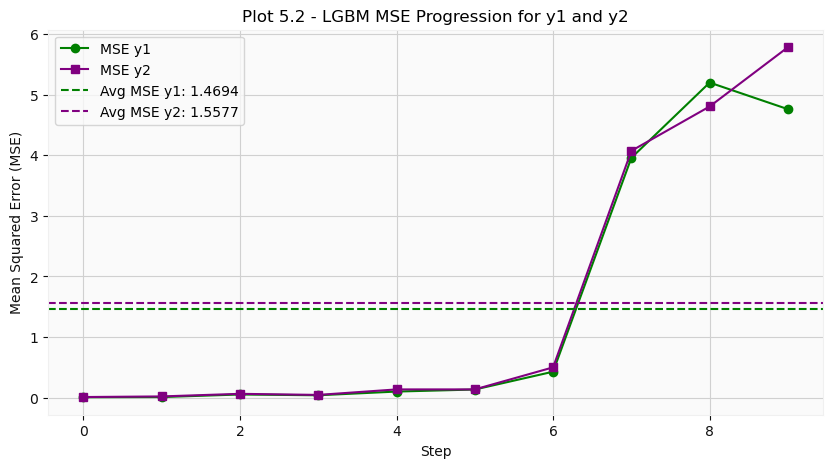

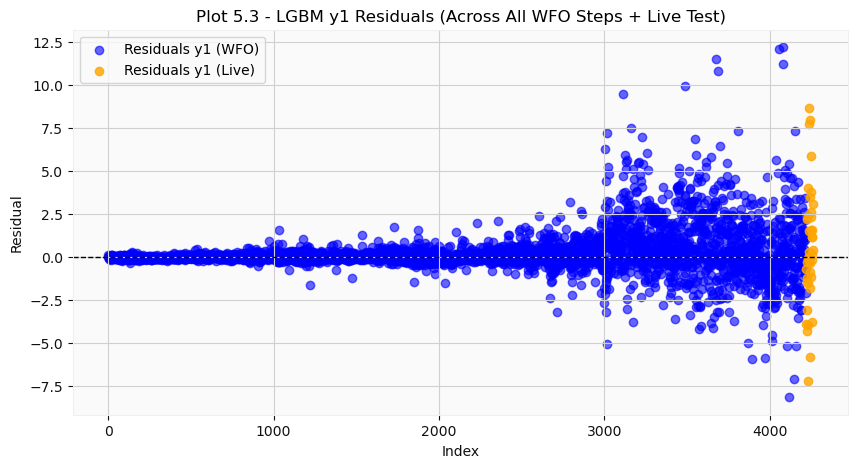

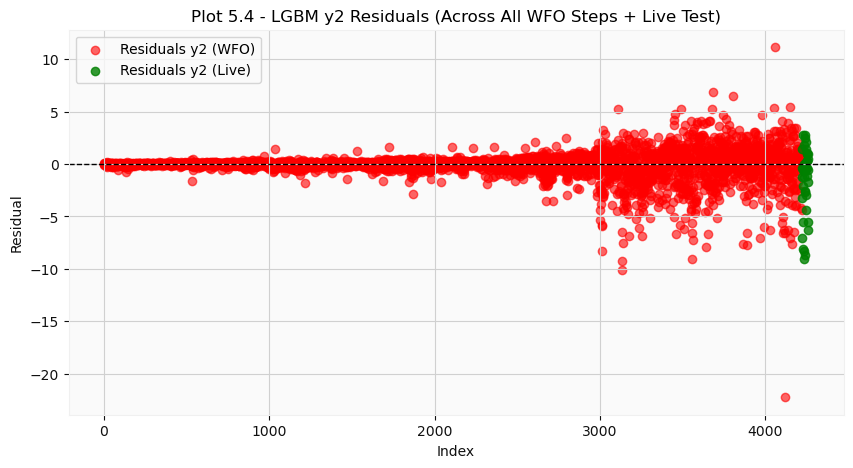

In [166]:
# Compute average MAE and MSE for y1 and y2
avg_mae_y1 = np.mean(mae_progress_y1)
avg_mae_y2 = np.mean(mae_progress_y2)
avg_mse_y1 = np.mean(mse_progress_y1)
avg_mse_y2 = np.mean(mse_progress_y2)

# Plot MAE for y1 and y2 with horizontal average lines
plt.figure(figsize=(10, 5))
plt.plot(mae_progress_y1, marker='o', linestyle='-', color='blue', label='MAE y1')
plt.plot(mae_progress_y2, marker='s', linestyle='-', color='red', label='MAE y2')
plt.axhline(avg_mae_y1, color='blue', linestyle='--', label=f'Avg MAE y1: {avg_mae_y1:.4f}')
plt.axhline(avg_mae_y2, color='red', linestyle='--', label=f'Avg MAE y2: {avg_mae_y2:.4f}')
plt.xlabel('Step')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Plot 5.1 - LGBM MAE Progression for y1 and y2')
plt.legend()
plt.grid(True)
plt.show()

# Plot MSE for y1 and y2 with horizontal average lines
plt.figure(figsize=(10, 5))
plt.plot(mse_progress_y1, marker='o', linestyle='-', color='green', label='MSE y1')
plt.plot(mse_progress_y2, marker='s', linestyle='-', color='purple', label='MSE y2')
plt.axhline(avg_mse_y1, color='green', linestyle='--', label=f'Avg MSE y1: {avg_mse_y1:.4f}')
plt.axhline(avg_mse_y2, color='purple', linestyle='--', label=f'Avg MSE y2: {avg_mse_y2:.4f}')
plt.xlabel('Step')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Plot 5.2 - LGBM MSE Progression for y1 and y2')
plt.legend()
plt.grid(True)
plt.show()

# Compute live residuals
X_live_y1 = X_live_y1.loc[y_live_y1.index].reset_index(drop=True)
X_live_y2 = X_live_y2.loc[y_live_y2.index].reset_index(drop=True)

predictions_live_y1 = lgbm_model_y1.predict(X_live_y1)
predictions_live_y2 = lgbm_model_y2.predict(X_live_y2)

residuals_live_y1 = y_live_y1.values - predictions_live_y1
residuals_live_y2 = y_live_y2.values - predictions_live_y2

# Plot residuals for y1 (including live residuals)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals_y1_all)), residuals_y1_all, color='blue', alpha=0.6, label='Residuals y1 (WFO)')
plt.scatter(range(len(residuals_y1_all), len(residuals_y1_all) + len(residuals_live_y1)), residuals_live_y1, 
            color='orange', alpha=0.8, label='Residuals y1 (Live)')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Plot 5.3 - LGBM y1 Residuals (Across All WFO Steps + Live Test)')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals for y2 (including live residuals)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(residuals_y2_all)), residuals_y2_all, color='red', alpha=0.6, label='Residuals y2 (WFO)')
plt.scatter(range(len(residuals_y2_all), len(residuals_y2_all) + len(residuals_live_y2)), residuals_live_y2, 
            color='green', alpha=0.8, label='Residuals y2 (Live)')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Plot 5.4 - LGBM y2 Residuals (Across All WFO Steps + Live Test)')
plt.legend()
plt.grid(True)
plt.show()

eval_df['lgbm_avg_mae_y1'] = avg_mae_y1
eval_df['lgbm_avg_mae_y2'] = avg_mae_y2
eval_df['lgbm_avg_mse_y1'] = avg_mse_y1
eval_df['lgbm_avg_mse_y2'] = avg_mse_y2

eval_df['lgbm_residuals_y1_all'] = residuals_y1_all
eval_df['lgbm_residuals_y2_all'] = residuals_y2_all

# Calculate padding size
pad_size = len(eval_df) - len(residuals_live_y1)

# Pad with NaNs at the start
eval_df['lgbm_residuals_live_y1'] = np.pad(
    residuals_live_y1, 
    (pad_size, 0), 
    mode='constant', 
    constant_values=np.nan
)

eval_df['lgbm_residuals_live_y2'] = np.pad(
    residuals_live_y2, 
    (pad_size, 0), 
    mode='constant', 
    constant_values=np.nan
)


--- LGBM Simulated Live Testing ---
NaNs in y_live_y1 after dropping: 0
NaNs in y_live_y2 after dropping: 0
NaNs in predictions_live_y1: 0
NaNs in predictions_live_y2: 0
Day 0: y1_forecast=3.9408, y2_forecast=0.6253
Day 0: y1_forecast=3.9408, y2_forecast=0.6253, Buy RR =6.3022, Sell RR =0.1587 
Triggered Buy Entry at day 0
Entry Price: 255.3092956542969, TP: 259.25007084528363, SL: 254.68399189737153, Buy RR: 6.302177377541322
SL hit at day 1 | Return: -0.24%
Day 1: y1_forecast=3.9084, y2_forecast=0.5930
Day 1: y1_forecast=3.9084, y2_forecast=0.5930, Buy RR =6.5914, Sell RR =0.1517 
Triggered Buy Entry at day 1
Entry Price: 251.9230194091797, TP: 255.83145474401454, SL: 251.3300555084062, Buy RR: 6.59135459972589
SL hit at day 2 | Return: -0.24%
Day 2: y1_forecast=3.8915, y2_forecast=0.5760
Day 2: y1_forecast=3.8915, y2_forecast=0.5760, Buy RR =6.7562, Sell RR =0.1480 
Triggered Buy Entry at day 2
Entry Price: 250.1449737548828, TP: 254.0364282716954, SL: 249.56899067213158, Buy RR: 6

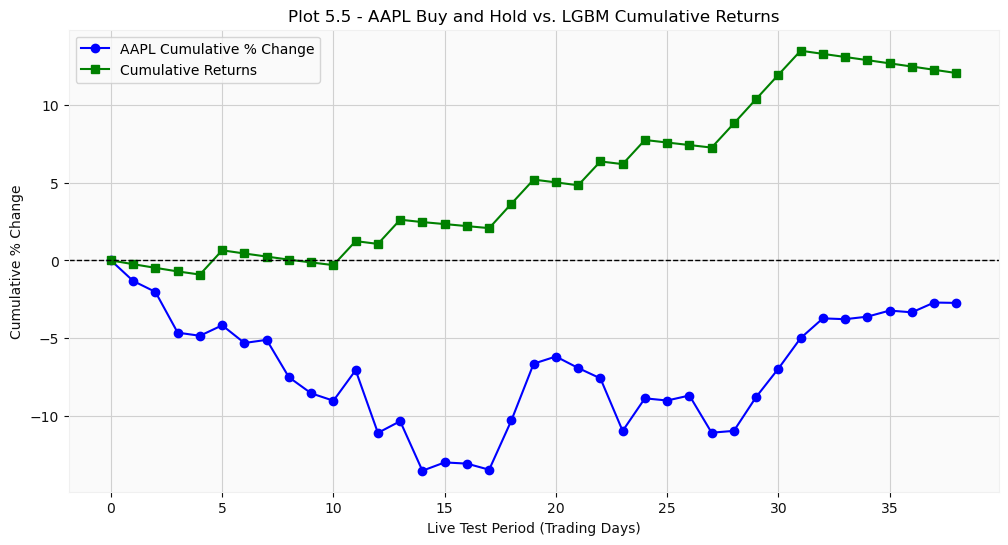

[-0.24492009 -0.48029513 -0.71055483 -0.91301581  0.65043453  0.44444113
  0.24707577  0.04818078 -0.13203839 -0.30415909  1.24218428  1.06201346
  2.62136131  2.46777373  2.34060804  2.209041    2.07809981  3.6523129
  5.20745424  5.02601508  4.84102081  6.3766374   6.20260629  7.75810734
  7.59481158  7.43263971  7.26791814  8.82442159 10.39751508 11.95951901
 13.50981213 13.30749406 13.10557626 12.90242826 12.69634405 12.49111386
 12.28118035 12.07142785]


In [170]:
# LGBM Simulated Live Trading using Trained Model
print("\n--- LGBM Simulated Live Testing ---")

# Create a new DataFrame to store copies 
lgbm_live_test_df = pd.DataFrame()

# Copy live y-values
lgbm_live_test_df["y_live_y1"] = y_live_y1.copy()
lgbm_live_test_df["y_live_y2"] = y_live_y2.copy()

# Drop NaNs and reset indices
lgbm_live_test_df.dropna(subset=["y_live_y1", "y_live_y2"], inplace=True)
lgbm_live_test_df.reset_index(drop=True, inplace=True)

# Copy live X-values and drop corresponding rows
X_live_y1_copy = X_live_y1.loc[lgbm_live_test_df["y_live_y1"].index].copy()
X_live_y2_copy = X_live_y2.loc[lgbm_live_test_df["y_live_y2"].index].copy()

# Store X_live copies in the DataFrame
for col in X_live_y1_copy.columns:
    lgbm_live_test_df[f"X_live_y1_{col}"] = X_live_y1_copy[col].values

for col in X_live_y2_copy.columns:
    lgbm_live_test_df[f"X_live_y2_{col}"] = X_live_y2_copy[col].values

# Make predictions using copied data
lgbm_live_test_df["predictions_live_y1"] = lgbm_model_y1.predict(X_live_y1_copy) + X_live_y2_copy["AAPL_Close"].values
lgbm_live_test_df["predictions_live_y2"] = lgbm_model_y2.predict(X_live_y2_copy) + X_live_y2_copy["AAPL_Close"].values

# Adjust live y-values by adding AAPL_Close
lgbm_live_test_df["y_live_y1"] += X_live_y2_copy["AAPL_Close"].values
lgbm_live_test_df["y_live_y2"] += X_live_y2_copy["AAPL_Close"].values

# Evaluate performance on the live test set
print("NaNs in y_live_y1 after dropping:", lgbm_live_test_df["y_live_y1"].isna().sum())
print("NaNs in y_live_y2 after dropping:", lgbm_live_test_df["y_live_y2"].isna().sum())
print("NaNs in predictions_live_y1:", lgbm_live_test_df["predictions_live_y1"].isna().sum())
print("NaNs in predictions_live_y2:", lgbm_live_test_df["predictions_live_y2"].isna().sum())

# --- Fixed Risk-Reward Thresholds ---
buy_rr_value = 1.0  
sell_rr_value = 1.0  

# Ensure AAPL_High, AAPL_Low, and AAPL_Close are correctly transformed back
X_live_y1_copy['AAPL_High'] = scaler_high.inverse_transform(
    X_live_y1_copy[X_high.columns]  
)[:, X_high.columns.get_loc("AAPL_High")] 

X_live_y2_copy['AAPL_Low'] = scaler_low.inverse_transform(
    X_live_y2_copy[X_low.columns]
)[:, X_low.columns.get_loc("AAPL_Low")]  

X_live_y2_copy['AAPL_Close'] = scaler_low.inverse_transform(
    X_live_y2_copy[X_low.columns]
)[:, X_low.columns.get_loc("AAPL_Close")]  

# Initialize tracking variables
returns = []
entry_price = None
take_profit = None
stop_loss = None

# Simulated Trading Logic
for i in range(len(lgbm_live_test_df["y_live_y1"]) - 2):
    
    # Store absolute values of predictions
    pred_high_i = abs(lgbm_live_test_df['predictions_live_y1'].iloc[i])
    pred_low_i = abs(lgbm_live_test_df['predictions_live_y2'].iloc[i])
    
    print(f"Day {i}: y1_forecast={pred_high_i:.4f}, y2_forecast={pred_low_i:.4f}")

    # Compute risk-reward ratios using stored absolute values
    buy_rr_current = pred_high_i / pred_low_i
    sell_rr_current = pred_low_i / pred_high_i

    print(f"Day {i}: y1_forecast={pred_high_i:.4f}, y2_forecast={pred_low_i:.4f}, Buy RR ={buy_rr_current:.4f}, Sell RR ={sell_rr_current:.4f} ")

    # Buy Entry Condition
    if buy_rr_current > buy_rr_value and entry_price is None:
        print(f"Triggered Buy Entry at day {i}")
        entry_price = X_live_y2_copy.iloc[i]["AAPL_Close"]  
        take_profit = X_live_y2_copy.iloc[i]["AAPL_Close"]  + pred_high_i
        stop_loss = X_live_y2_copy.iloc[i]["AAPL_Close"]  - pred_low_i
        print(f"Entry Price: {entry_price}, TP: {take_profit}, SL: {stop_loss}, Buy RR: {buy_rr_current}")

    # Sell Entry Condition
    if sell_rr_current > sell_rr_value and entry_price is None:
        print(f"Triggered Sell Entry at day {i}")
        entry_price = X_live_y2_copy.iloc[i]["AAPL_Close"]  
        take_profit = X_live_y2_copy.iloc[i]["AAPL_Close"] - pred_low_i
        stop_loss = X_live_y2_copy.iloc[i]["AAPL_Close"]  + pred_high_i
        print(f"Entry Price: {entry_price}, TP: {take_profit}, SL: {stop_loss}, Sell RR: {sell_rr_current}")

    # Buy Exit
    if entry_price is not None and (take_profit > stop_loss):
        high = X_live_y1_copy.iloc[i + 1]["AAPL_High"]
        low = X_live_y2_copy.iloc[i + 1]["AAPL_Low"]
    
        # Take Profit Hit
        if high >= take_profit:  
            return_value = (((take_profit - entry_price) / entry_price) * 100) 
            print(f"TP hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None
    
        # Stop Loss Hit
        elif low <= stop_loss:  
            return_value = (((entry_price - stop_loss) / entry_price) * -100) 
            print(f"SL hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None

        if i == len(lgbm_live_test_df["y_live_y1"]) - 3 and entry_price is not None:
            exit_price = X_live_y2_copy.iloc[i + 1]["AAPL_Close"]  
            return_value = (((exit_price - entry_price) / entry_price) * 100)  
            print(f"Close Open Position at day {i + 1} | Exit Price: {exit_price} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None

    # Sell Exit
    if entry_price is not None and (take_profit < stop_loss):
        high = X_live_y1_copy.iloc[i + 1]["AAPL_High"]
        low = X_live_y2_copy.iloc[i + 1]["AAPL_Low"]
    
        # Take Profit Hit
        if low <= take_profit:  
            return_value = (((entry_price - take_profit) / entry_price) * 100) 
            print(f"TP hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None
    
        # Stop Loss Hit
        elif high >= stop_loss:  
            return_value = (((stop_loss - entry_price) / entry_price) * -100) 
            print(f"SL hit at day {i + 1} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None

        # Force Exit on Last Iteration if Trade is Still Open
        if i == len(lgbm_live_test_df["y_live_y1"]) - 3 and entry_price is not None:
            exit_price = X_live_y2_copy.iloc[i + 1]["AAPL_Close"] 
            return_value = (((entry_price - exit_price) / entry_price) * 100)  
            print(f"Close Open Position at day {i + 1} | Exit Price: {exit_price} | Return: {return_value:.2f}%")
            returns.append(return_value)
            entry_price, take_profit, stop_loss = None, None, None  
  
# Compute cumulative percentage change for AAPL_Close
aapl_cumulative_pct_change = X_live_y2_copy["AAPL_Close"].pct_change().fillna(0).cumsum() * 100  
aapl_cumulative_pct_change = aapl_cumulative_pct_change.iloc[:-2]

# Convert returns list to cumulative sum array
cumulative_returns = np.cumsum(returns)  

# Create Trading Day Index
trading_days = list(range(len(lgbm_live_test_df["y_live_y1"]) - 2))

# Cumulative Returns Period
full_cumulative_returns = np.zeros(len(trading_days))  
start_index = len(trading_days) - len(cumulative_returns) 
full_cumulative_returns[start_index:] = cumulative_returns  

# Plot AAPL cumulative % change
plt.figure(figsize=(12, 6))
plt.plot(aapl_cumulative_pct_change.index, aapl_cumulative_pct_change, linestyle='-', marker='o', color='blue', label='AAPL Cumulative % Change')

# Plot corrected cumulative returns (aligned properly)
plt.plot(trading_days, full_cumulative_returns, linestyle='-', marker='s', color='green', label='Cumulative Returns')

# Add labels and title
plt.xlabel('Live Test Period (Trading Days)')
plt.ylabel('Cumulative % Change')
plt.title('Plot 5.5 - AAPL Buy and Hold vs. LGBM Cumulative Returns')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
print(cumulative_returns)

# Ensure all arrays are of float type before padding
full_cumulative_returns = full_cumulative_returns.astype(float)

# Calculate padding sizes individually for each column
pad_size_lgbm_returns = len(eval_df) - len(full_cumulative_returns)

# Pad lgbm_cumulative_returns
eval_df['lgbm_cumulative_returns'] = np.pad(
    full_cumulative_returns, 
    (pad_size_lgbm_returns, 0),  
    mode='constant', 
    constant_values=np.nan
)

In [174]:
# Summary Metrics
metrics_summary = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'MAE Y1': [
        eval_df['rf_avg_mae_y1'].iloc[0],
        eval_df['xgb_avg_mae_y1'].iloc[0],
        eval_df['lgbm_avg_mae_y1'].iloc[0]
    ],
    'MAE Y2': [
        eval_df['rf_avg_mae_y2'].iloc[0],
        eval_df['xgb_avg_mae_y2'].iloc[0],
        eval_df['lgbm_avg_mae_y2'].iloc[0]
    ],
    'MSE Y1': [
        eval_df['rf_avg_mse_y1'].iloc[0],
        eval_df['xgb_avg_mse_y1'].iloc[0],
        eval_df['lgbm_avg_mse_y1'].iloc[0]
    ],
    'MSE Y2': [
        eval_df['rf_avg_mse_y2'].iloc[0],
        eval_df['xgb_avg_mse_y2'].iloc[0],
        eval_df['lgbm_avg_mse_y2'].iloc[0]
    ]
})

# Display the Performance Metrics
print("Model Performance Metrics:")
display(metrics_summary)  

Model Performance Metrics:


,Model,MAE Y1,MAE Y2,MSE Y1,MSE Y2
0,Random Forest,0.581384,0.657597,1.416263,1.663271
1,XGBoost,0.595294,0.628610,1.474726,1.658244
2,LightGBM,0.586383,0.610303,1.469354,1.557656


In [176]:
# Model Residuals Comparison
residuals_summary = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM'],
    'Residuals Y1 (All)': [
        eval_df['rf_residuals_y1_all'].abs().mean(),
        eval_df['xgb_residuals_y1_all'].abs().mean(),
        eval_df['lgbm_residuals_y1_all'].abs().mean()
    ],
    'Residuals Y2 (All)': [
        eval_df['rf_residuals_y2_all'].abs().mean(),
        eval_df['xgb_residuals_y2_all'].abs().mean(),
        eval_df['lgbm_residuals_y2_all'].abs().mean()
    ],
    'Residuals Y1 (Live)': [
        eval_df['rf_residuals_live_y1'].abs().mean(),
        eval_df['xgb_residuals_live_y1'].abs().mean(),
        eval_df['lgbm_residuals_live_y1'].abs().mean()
    ],
    'Residuals Y2 (Live)': [
        eval_df['rf_residuals_live_y2'].abs().mean(),
        eval_df['xgb_residuals_live_y2'].abs().mean(),
        eval_df['lgbm_residuals_live_y2'].abs().mean()
    ]
})

# Display the residuals summary table
print("Model Residuals:")
display(residuals_summary)  

Model Residuals:


,Model,Residuals Y1 (All),Residuals Y2 (All),Residuals Y1 (Live),Residuals Y2 (Live)
0,Random Forest,0.581384,0.657597,2.528548,2.474256
1,XGBoost,0.595294,0.628610,2.742041,2.454269
2,LightGBM,0.586383,0.610303,2.531215,2.557402


In [178]:
# Cumulative Returns Summary
cumulative_returns_summary = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'AAPL Buy & Hold'],
    'Cumulative Returns (%)': [
        eval_df['rf_cumulative_returns'].dropna().iloc[-1],  
        eval_df['xgb_cumulative_returns'].dropna().iloc[-1],  
        eval_df['lgbm_cumulative_returns'].dropna().iloc[-1],
        eval_df['aapl_cumulative_pct_change'].dropna().iloc[-1] 
    ]
})

# Display the cumulative returns summary table
print("Model Cumulative Returns:")
display(cumulative_returns_summary)  

Model Cumulative Returns:


,Model,Cumulative Returns (%)
0,Random Forest,12.806254
1,XGBoost,16.281852
2,LightGBM,12.071428
3,AAPL Buy & Hold,-2.739763


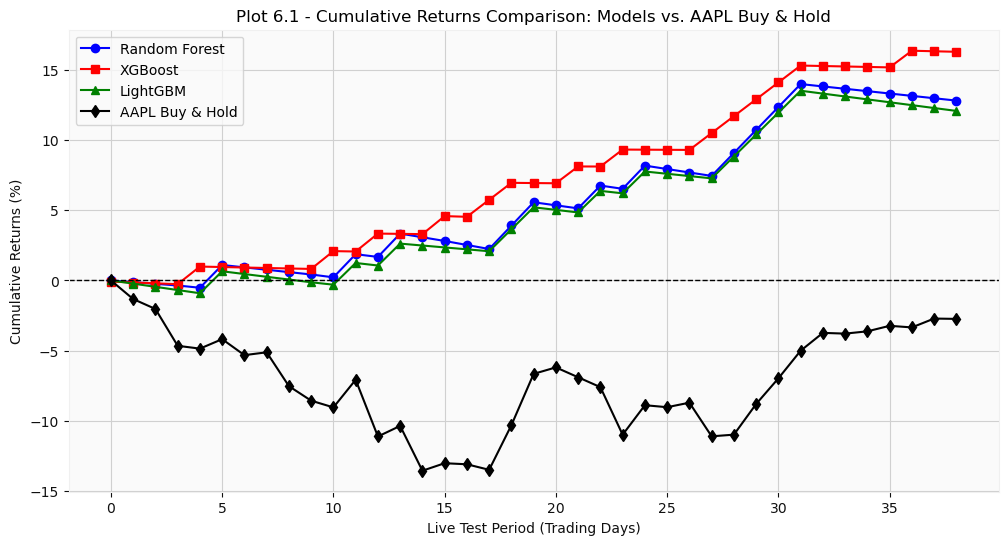

In [180]:
# Plot Cumulative Returns for All Models
plt.figure(figsize=(12, 6))

# Plot Random Forest cumulative returns
plt.plot(eval_df['trading_days'], eval_df['rf_cumulative_returns'], linestyle='-', marker='o', label='Random Forest', color='blue')

# Plot XGBoost cumulative returns
plt.plot(eval_df['trading_days'], eval_df['xgb_cumulative_returns'], linestyle='-', marker='s', label='XGBoost', color='red')

# Plot LightGBM cumulative returns
plt.plot(eval_df['trading_days'], eval_df['lgbm_cumulative_returns'], linestyle='-', marker='^', label='LightGBM', color='green')

# Plot AAPL Buy & Hold cumulative returns
plt.plot(eval_df['trading_days'], eval_df['aapl_cumulative_pct_change'], linestyle='-', marker='d', label='AAPL Buy & Hold', color='black')

# Add labels and title
plt.xlabel('Live Test Period (Trading Days)')
plt.ylabel('Cumulative Returns (%)')
plt.title('Plot 6.1 - Cumulative Returns Comparison: Models vs. AAPL Buy & Hold')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Reference line at 0%
plt.legend()
plt.grid(True)

# Show the plot
plt.show()